<a href="https://colab.research.google.com/github/Vennylts/Loan-Repayment-Prediction/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

# 0. Introduction

The goal of this notebook is to develop a model that can predict whether a given loan application will default, based on the outcomes of previously funded loans. In other words, this is a binary classification task.

From the given problem statements & datasets, we infer the following process for a prospective borrower (hereafter: client).
1. Client submits loan application.
2. MoneyLion sends client details to underwriters for fraud detection (can be automated, manual, or both).
3. If there are no clear & obvious signs of fraud, application is approved.
4. Once a loan deposit is made, application gets funded.

Ideally, we'd like our model to operate between steps 2 & 3, assessing the risk of each application & acting as a final guardrail before a loan ultimately gets approved. Naturally, we can assume that step 2 filters out a large majority of fraudulent applications, allowing us to focus our attention solely on risk assessment.

We hope that this will provide MoneyLion a straightforward way of evaluating the risk of each application against their own risk tolerance, opening up the channel for more well-informed business decisions.

# 1. Import Dependencies

We begin by importing the necessary libraries.

In [ ]:
# Data analysis
import math
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_theme(style='whitegrid', palette='pastel')

# Preprocessing
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from pdpbox import pdp

# Utility functions
from utils import *

# 2. Exploratory Data Analysis (EDA)

Read in the relevant data and make sure everything is in good shape, beginning with `loan.csv`.

In [ ]:
# Read data
loan = pd.read_csv('../data/loan.csv', parse_dates=['applicationDate', 'originatedDate'])
# Display result
loan

loanId                          anon_ssn payFrequency    apr  \
0       LL-I-07399092  beff4989be82aab4a5b47679216942fd            B  360.0   
1       LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
2       LL-I-10707532  3c174ae9e2505a5f9ddbff9843281845            B  590.0   
3       LL-I-02272596  9be6f443bb97db7e95fa0c281d34da91            B  360.0   
4       LL-I-09542882  63b5494f60b5c19c827c7b068443752c            B  590.0   
...               ...                               ...          ...    ...   
577677  LL-I-12122269  801262d04720d32040612759857f4147            B  590.0   
577678  LL-I-16183462  e37750de9d99a67e0fa96a51e86fdf5b            S  490.0   
577679  LL-I-06962710  d7e55e85266208ac4c353f42ebcde5ca            B  590.0   
577680  LL-I-01253468  c3b35307cb36116bf59574f9138d3dad            B  550.0   
577681  LL-I-04733921  dc0a43b16c037ee5d0142daebb5db83a            I  590.0   

               applicationDate  originated          originatedDate  nPaidOff  \
0      2016-02-23 17:29:01.940       False                     NaT       0.0   
1      2016-01-19 22:07:36.778        True 2016-01-20 15:49:18.846       0.0   
2      2016-08-01 13:51:14.709       False                     NaT       0.0   
3      2015-08-06 23:58:08.880       False                     NaT       0.0   
4      2016-06-05 22:31:34.304       False                     NaT       0.0   
...                        ...         ...                     ...       ...   
577677 2016-11-08 17:32:33.554       False                     NaT       0.0   
577678 2017-01-24 22:20:59.818       False                     NaT       0.0   
577679 2016-02-02 03:05:47.797       False                     NaT       0.0   
577680 2015-05-21 20:19:49.639       False                     NaT       0.0   
577681 2015-11-17 22:04:20.862       False                     NaT       0.0   

        approved  isFunded             loanStatus  loanAmount  \
0          False         0  Withdrawn Application       500.0   
1           True         1          Paid Off Loan      3000.0   
2          False         0  Withdrawn Application       400.0   
3          False         0  Withdrawn Application       500.0   
4          False         0               Rejected       350.0   
...          ...       ...                    ...         ...   
577677     False         0  Withdrawn Application       400.0   
577678     False         0  Withdrawn Application      1000.0   
577679     False         0  Withdrawn Application       300.0   
577680     False         0  Withdrawn Application       300.0   
577681     False         0               Rejected       400.0   

        originallyScheduledPaymentAmount state     leadType  leadCost  \
0                                 978.27    IL  bvMandatory         6   
1                                6395.19    CA    prescreen         0   
2                                1199.45    MO  bvMandatory         3   
3                                1074.05    IL  bvMandatory         3   
4                                 814.37    NV  bvMandatory         3   
...                                  ...   ...          ...       ...   
577677                           1292.41    NV  bvMandatory         3   
577678                           2592.39    MO         lead        25   
577679                            844.75    IN  bvMandatory         6   
577680                            770.80    OH      organic         6   
577681                           1214.63    OH  bvMandatory         6   

       fpStatus            clarityFraudId  hasCF  
0           NaN  5669ef78e4b0c9d3936440e6      1  
1       Checked  569eb3a3e4b096699f685d64      1  
2           NaN  579eab11e4b0d0502870ef2f      1  
3           NaN  555b1e95e4b0f6f11b267c18      1  
4           NaN  5754a91be4b0c6a2bf424772      1  
...         ...                       ...    ...  
577677      NaN  58220cdde4b051c58d919c1f      1  
577678      NaN  5887d349e4b08f249ac45e

Also load the underwriting reports from `clarity_underwriting_variables.csv`.

In [ ]:
# Read data
underwriting_var = pd.read_csv('../data/clarity_underwriting_variables.csv', low_memory=False)
# Display result
underwriting_var

.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago  \
0                                                    8.0                     
1                                                    5.0                     
2                                                    9.0                     
3                                                    3.0                     
4                                                    5.0                     
...                                                  ...                     
49747                                                2.0                     
49748                                                6.0                     
49749                                                4.0                     
49750                                                3.0                     
49751                                                5.0                     

       .underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago  \
0                                                    2.0                          
1                                                    2.0                          
2                                                    4.0                          
3                                                    2.0                          
4                                                    5.0                          
...                                                  ...                          
49747                                                2.0                          
49748                                                4.0                          
49749                                                4.0                          
49750                                                3.0                          
49751                                                3.0                          

       .underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago  \
0                                                    2.0                    
1                                                    2.0                    
2                                                    2.0                    
3                                                    2.0                    
4                                                    2.0                    
...                                                  ...                    
49747                                                2.0                    
49748                                                1.0                    
49749                                                1.0                    
49750                                                2.0                    
49751                                                2.0                    

       .underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago  \
0                                                    2.0                  
1                                                    2.0                  
2                                                    3.0                  
3                                                    2.0                  
4                                                    2.0                  
...                                                  ...                  
49747                                                2.0                  
49748                                                4.0                  
49749                                                4.0                  
49750                                                2.0                  
49751                                                2.0                  

       .underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago  \
0                                                    8.0                     
1                                                   11.0                     
2            

Note, we'll refrain from using `payment.csv` to prevent target leakages during model training. More specifically, since the goal is for the model to assess the risk of applications that have yet to be approved, it will typically not have access to the payment data stored in `payment.csv` at the time of predictions. See "Further Work" section for related discussions.

## 2.1 Data Transformation

Join the two dataframes along the appropriate ID column, and filter by funded loans.

In [ ]:
# Merge dataframes
df = loan.merge(underwriting_var, left_on='clarityFraudId', right_on='underwritingid', how='left')
# Filter by funded loans
df = df[df['isFunded'] == 1]
# Display results
df

loanId                          anon_ssn payFrequency    apr  \
1       LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
15      LL-I-12263369  accf40708233e8b7d05fcb89d5a9c081            B  475.0   
33      LL-I-17826953  7529d29c9d943cc55bc71a85d9c6b7a3            W  645.0   
47      LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c            S  490.0   
54      LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc            B  590.0   
...               ...                               ...          ...    ...   
577564  LL-I-12367915  55392b05f72f8c3e32e5157612406ba8            B  565.0   
577590  LL-I-15280684  73690518af906288434b2a0cfd972fe0            M  645.0   
577617  LL-I-09897110  0538f828b4a0b44502ead5a8033ee779            B  449.0   
577653  LL-I-14178923  d9a63e9e15b862fcaaf3653c52e1f16c            B  625.0   
577662  LL-I-13311312  043dd86c24c63c8968082fa3ad7a8911            W  645.0   

               applicationDate  originated          originatedDate  nPaidOff  \
1      2016-01-19 22:07:36.778        True 2016-01-20 15:49:18.846       0.0   
15     2016-11-28 19:54:22.982        True 2016-11-29 20:30:40.640       2.0   
33     2017-03-01 15:55:41.823        True 2017-03-01 16:15:13.016       0.0   
47     2017-01-31 17:48:17.381        True 2017-01-31 18:00:14.520       2.0   
54     2016-08-27 09:08:05.442        True 2016-08-29 15:05:04.014       0.0   
...                        ...         ...                     ...       ...   
577564 2016-12-01 16:57:49.231        True 2016-12-01 17:28:21.872       3.0   
577590 2017-01-14 19:43:08.685        True 2017-01-14 20:00:10.426       0.0   
577617 2016-06-22 01:10:50.110        True 2016-06-22 21:46:54.359       0.0   
577653 2016-12-30 15:49:39.785        True 2016-12-30 16:00:12.500       0.0   
577662 2016-12-16 20:20:30.157        True 2016-12-16 23:15:06.874       0.0   

        approved  isFunded     loanStatus  loanAmount  \
1           True         1  Paid Off Loan      3000.0   
15          True         1       New Loan       350.0   
33          True         1       New Loan       400.0   
47          True         1  Paid Off Loan      1250.0   
54          True         1  Paid Off Loan       800.0   
...          ...       ...            ...         ...   
577564      True         1  Paid Off Loan       600.0   
577590      True         1  Paid Off Loan       375.0   
577617      True         1  Paid Off Loan       400.0   
577653      True         1       New Loan       600.0   
577662      True         1  Paid Off Loan       300.0   

        originallyScheduledPaymentAmount state      leadType  leadCost  \
1                                6395.19    CA     prescreen         0   
15                                893.88    MO       organic         0   
33                               1364.87    NJ          lead        40   
47                               3313.78    MO       organic         0   
54                               2432.08    CA   bvMandatory        10   
...                                  ...   ...           ...       ...   
577564                           1670.18    CA  rc_returning         0   
577590                           1042.40    AL          lead        25   
577617                            664.12    WI          lead        40   
577653                           1868.88    IN          lead        25   
577662                           1034.38    CT          lead         6   

       fpStatus            clarityFraudId  hasCF  \
1       Checked  569eb3a3e4b096699f685d64      1   
15      Checked                       NaN      0   
33      Checked  58b6eef8e4b0b6fca82fd426      1   
47      Checked  58450a15e4b0bb9d6d7344c7      1   
54      Checked  578f9346e4b0810ad5e7b72e      1   
...         ...                       ...    ...   
577564  Checked                       NaN      0   
577590  Checked  587a7f49e4b08f2485d48358      1   
577617  Checked  5769e592e4b0ab6c50364d45      1   
577653  Che

Then, for brevity, we drop all columns that initially appear to hold no meaningful information. This includes most features from `clarity_underwriting_variables.csv`, since (1) our model is primarily tasked with risk assessment, not fraud detection, and (2) we'll assume that `clearfraudscore` sufficiently summarizes the findings of the underwriting team.

In [ ]:
# Print clearfraudscore description
underwriting_var_columns = pd.read_csv('../data/clarity_underwriting_dictionary.csv')
cfs_desc = underwriting_var_columns[underwriting_var_columns['fieldName_in_file'] == 'clearFraudScore']['Description'].values[0]
print(f'Clear Fraud Score: {cfs_desc}.')

Clear Fraud Score: fraud score provided by clarity. Higher score suggests lower default probability.


In [ ]:
# Drop irrelevant columns
df = df[['loanId',
         'anon_ssn',
         'payFrequency',
         'apr',
         'applicationDate',
         'originatedDate',
         'nPaidOff',
         'loanStatus',
         'loanAmount',
         'originallyScheduledPaymentAmount',
         'state',
         'leadType',
         'leadCost',
         'fpStatus',
         'hasCF',
         'clearfraudscore']]
# Display results
df

loanId                          anon_ssn payFrequency    apr  \
1       LL-I-06644937  464f5d9ae4fa09ece4048d949191865c            B  199.0   
15      LL-I-12263369  accf40708233e8b7d05fcb89d5a9c081            B  475.0   
33      LL-I-17826953  7529d29c9d943cc55bc71a85d9c6b7a3            W  645.0   
47      LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c            S  490.0   
54      LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc            B  590.0   
...               ...                               ...          ...    ...   
577564  LL-I-12367915  55392b05f72f8c3e32e5157612406ba8            B  565.0   
577590  LL-I-15280684  73690518af906288434b2a0cfd972fe0            M  645.0   
577617  LL-I-09897110  0538f828b4a0b44502ead5a8033ee779            B  449.0   
577653  LL-I-14178923  d9a63e9e15b862fcaaf3653c52e1f16c            B  625.0   
577662  LL-I-13311312  043dd86c24c63c8968082fa3ad7a8911            W  645.0   

               applicationDate          originatedDate  nPaidOff  \
1      2016-01-19 22:07:36.778 2016-01-20 15:49:18.846       0.0   
15     2016-11-28 19:54:22.982 2016-11-29 20:30:40.640       2.0   
33     2017-03-01 15:55:41.823 2017-03-01 16:15:13.016       0.0   
47     2017-01-31 17:48:17.381 2017-01-31 18:00:14.520       2.0   
54     2016-08-27 09:08:05.442 2016-08-29 15:05:04.014       0.0   
...                        ...                     ...       ...   
577564 2016-12-01 16:57:49.231 2016-12-01 17:28:21.872       3.0   
577590 2017-01-14 19:43:08.685 2017-01-14 20:00:10.426       0.0   
577617 2016-06-22 01:10:50.110 2016-06-22 21:46:54.359       0.0   
577653 2016-12-30 15:49:39.785 2016-12-30 16:00:12.500       0.0   
577662 2016-12-16 20:20:30.157 2016-12-16 23:15:06.874       0.0   

           loanStatus  loanAmount  originallyScheduledPaymentAmount state  \
1       Paid Off Loan      3000.0                           6395.19    CA   
15           New Loan       350.0                            893.88    MO   
33           New Loan       400.0                           1364.87    NJ   
47      Paid Off Loan      1250.0                           3313.78    MO   
54      Paid Off Loan       800.0                           2432.08    CA   
...               ...         ...                               ...   ...   
577564  Paid Off Loan       600.0                           1670.18    CA   
577590  Paid Off Loan       375.0                           1042.40    AL   
577617  Paid Off Loan       400.0                            664.12    WI   
577653       New Loan       600.0                           1868.88    IN   
577662  Paid Off Loan       300.0                           1034.38    CT   

            leadType  leadCost fpStatus  hasCF  clearfraudscore  
1          prescreen         0  Checked      1            879.0  
15           organic         0  Checked      0              NaN  
33              lead        40  Checked      1            658.0  
47           organic         0  Checked      1            835.0  
54       bvMandatory        10  Checked      1            624.0  
...              ...       ...      ...    ...              ...  
577564  rc_returning         0  Checked      0              NaN  
577590          lead        25  Checked      1            700.0  
577617          lead        40  Checked      1            806.0  
577653          lead        25  Checked      1            769.0  
577662          lead         6  Checked      1            827.0  

[38982 rows x 16 columns]

## 2.2 Handle Missing Values

We proceed accordingly by checking whether there are any missing values present in our data.

In [ ]:
# Compute % of missing values in each column
check_nan(df)

Percentage of missing values in each column:

clearfraudscore                     17.69
nPaidOff                             0.05
fpStatus                             0.02
loanId                               0.00
anon_ssn                             0.00
payFrequency                         0.00
apr                                  0.00
applicationDate                      0.00
originatedDate                       0.00
loanStatus                           0.00
loanAmount                           0.00
originallyScheduledPaymentAmount     0.00
state                                0.00
leadType                             0.00
leadCost                             0.00
hasCF                                0.00
dtype: float64



Notice that `clearfraudscore` and `nPaidOff` both have `NaN` values that we must handle (we'll most likely end up dropping `fpStatus` so we'll deal with that column later). Beginning with the former, let's first observe how the data are distributed.

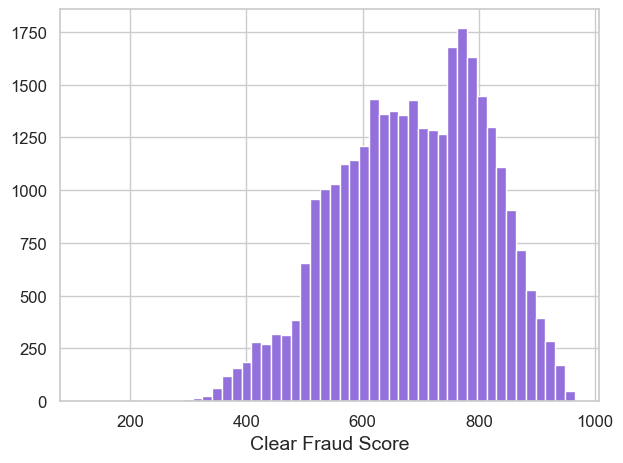

In [ ]:
# Plot histogram of clearfraudscore
df['clearfraudscore'].plot(kind='hist', bins=50, color='mediumpurple')
plt.xlabel('Clear Fraud Score', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

We observe that the data are Gaussian (normal) with a slight negative skew, implying that the median value will be of use to us here.

Similarly, let's observe how the latter data are distributed.

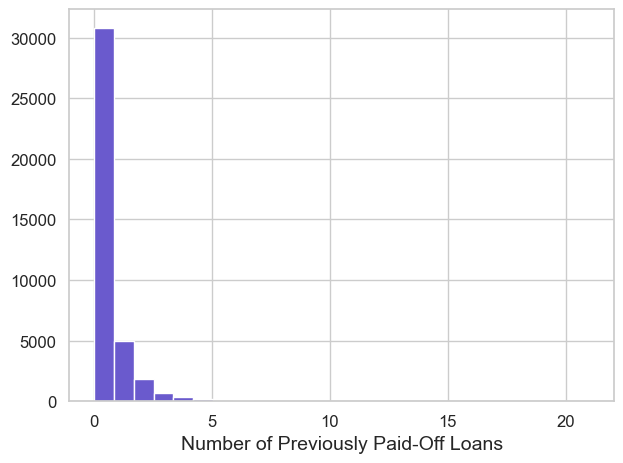

In [ ]:
# Plot histogram of nPaidOff
df['nPaidOff'].plot(kind='hist', bins=25, color='slateblue')
plt.xlabel('Number of Previously Paid-Off Loans', fontsize=14)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


We notice that the data are heavily concentrated near 0, leading us to believe the mode value should be used.

In [ ]:
# Fill missing values
df.loc[df['clearfraudscore'].isna(), 'clearfraudscore'] = df['clearfraudscore'].median()
df.loc[df['nPaidOff'].isna(), 'nPaidOff'] = df['nPaidOff'].mode()[0]

## 2.3 Impute Categorical Variables

Next, we'll look over the dtype of each column, keeping an eye out for any categorical variables

In [ ]:
# Print concise summary of df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38982 entries, 1 to 577662
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   loanId                            38982 non-null  object        
 1   anon_ssn                          38982 non-null  object        
 2   payFrequency                      38982 non-null  object        
 3   apr                               38982 non-null  float64       
 4   applicationDate                   38982 non-null  datetime64[ns]
 5   originatedDate                    38982 non-null  datetime64[ns]
 6   nPaidOff                          38982 non-null  float64       
 7   loanStatus                        38982 non-null  object        
 8   loanAmount                        38982 non-null  float64       
 9   originallyScheduledPaymentAmount  38982 non-null  float64       
 10  state                             38982 non-n

We notice several columns with `dtype == 'object'`, which we'll address in order:

- `loanId` & `anon_ssn` are unique identifiers -> no further action required
- `payFrequency` may be of use to us -> **further action required**
- `loanStatus` will be addressed during feature engineering -> skip for now
- `state` contains demographic data, which we'll refrain from using due to the potential for bias/discrimination (see "Further Work" section) -> drop column
- `leadType` may be of use to us -> **further action required**
- `fpStatus` contains data that won't be available during model prediction (i.e. target leakage) -> drop column

It follows, since `payFrequency` is an ordinal variable, whereas `leadType` is a nominal variable, we'll apply ordinal & one-hot encoding, respectively.

In [ ]:
# Drop irrelevant columns
df = df.drop(columns=['state', 'fpStatus'])
# Ordinal encoding
df['payFrequency'] = df['payFrequency'].map({'W': 0,
                                             'B': 1,
                                             'S': 2,
                                             'M': 3,
                                             'I': 4})
# One-hot encoding
df = pd.get_dummies(df, columns=['leadType'])
# Display results
df

loanId                          anon_ssn  payFrequency    apr  \
1       LL-I-06644937  464f5d9ae4fa09ece4048d949191865c             1  199.0   
15      LL-I-12263369  accf40708233e8b7d05fcb89d5a9c081             1  475.0   
33      LL-I-17826953  7529d29c9d943cc55bc71a85d9c6b7a3             0  645.0   
47      LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c             2  490.0   
54      LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc             1  590.0   
...               ...                               ...           ...    ...   
577564  LL-I-12367915  55392b05f72f8c3e32e5157612406ba8             1  565.0   
577590  LL-I-15280684  73690518af906288434b2a0cfd972fe0             3  645.0   
577617  LL-I-09897110  0538f828b4a0b44502ead5a8033ee779             1  449.0   
577653  LL-I-14178923  d9a63e9e15b862fcaaf3653c52e1f16c             1  625.0   
577662  LL-I-13311312  043dd86c24c63c8968082fa3ad7a8911             0  645.0   

               applicationDate          originatedDate  nPaidOff  \
1      2016-01-19 22:07:36.778 2016-01-20 15:49:18.846       0.0   
15     2016-11-28 19:54:22.982 2016-11-29 20:30:40.640       2.0   
33     2017-03-01 15:55:41.823 2017-03-01 16:15:13.016       0.0   
47     2017-01-31 17:48:17.381 2017-01-31 18:00:14.520       2.0   
54     2016-08-27 09:08:05.442 2016-08-29 15:05:04.014       0.0   
...                        ...                     ...       ...   
577564 2016-12-01 16:57:49.231 2016-12-01 17:28:21.872       3.0   
577590 2017-01-14 19:43:08.685 2017-01-14 20:00:10.426       0.0   
577617 2016-06-22 01:10:50.110 2016-06-22 21:46:54.359       0.0   
577653 2016-12-30 15:49:39.785 2016-12-30 16:00:12.500       0.0   
577662 2016-12-16 20:20:30.157 2016-12-16 23:15:06.874       0.0   

           loanStatus  loanAmount  originallyScheduledPaymentAmount  leadCost  \
1       Paid Off Loan      3000.0                           6395.19         0   
15           New Loan       350.0                            893.88         0   
33           New Loan       400.0                           1364.87        40   
47      Paid Off Loan      1250.0                           3313.78         0   
54      Paid Off Loan       800.0                           2432.08        10   
...               ...         ...                               ...       ...   
577564  Paid Off Loan       600.0                           1670.18         0   
577590  Paid Off Loan       375.0                           1042.40        25   
577617  Paid Off Loan       400.0                            664.12        40   
577653       New Loan       600.0                           1868.88        25   
577662  Paid Off Loan       300.0                           1034.38         6   

        hasCF  clearfraudscore  leadType_bvMandatory  leadType_california  \
1           1            879.0                     0                    0   
15          0            693.0                     0                    0   
33          1            658.0                     0                    0   
47          1            835.0                     0                    0   
54          1            624.0                     1                    0   
...       ...              ...                   ...                  ...   
577564      0            693.0                     0                    0   
577590      1            700.0                     0                    0   
577617      1            806.0                     0                    0   
577653      1            769.0                     0                    0   
577662      1            827.0                     0                    0   

        leadType_express  leadType_instant-offer  leadType_lead  \
1                      0                       0              0   
15                     0                       0              0   
33                     0                       0              1   
47                     0                       0              0   
54  

## 2.4 Feature Engineering

Moving on, we'd now like to create a target variable to represent whether a given loan application has defaulted or not. For this, we turn to the `loanStatus` column, which gives us a high-level overview of the outcomes of each application.

In [ ]:
# Perform a normalized count of unique values in loanStatus
df['loanStatus'].value_counts(normalize=True).apply(lambda x: f'{x * 100:.2f}%')

Paid Off Loan                  29.31%
External Collection            29.07%
New Loan                       20.81%
Internal Collection            14.27%
Returned Item                   3.03%
Settlement Paid Off             1.82%
Settled Bankruptcy              0.83%
Pending Paid Off                0.43%
Charged Off Paid Off            0.41%
Charged Off                     0.00%
Settlement Pending Paid Off     0.00%
Name: loanStatus, dtype: object

We gather the following information:
1. `Paid Off Loan` and `Settlement Paid Off` seem to indicate the loan was paid/settled in full, which are favorable outcomes from the perspective of the lender (MoneyLion).
2. `Settled Bankruptcy` and `Charged Off` indicates the client failed to fulfill their financial obligations, necessitating 3rd-party intervention & a loss on MoneyLion's end. These outcomes are what we're trying to avoid.
3. All other values indicate that the status of the loan is still ongoing, and are thus irrelevant to our analyses.

With that, we can create a new `target` column with a binary value indicating whether `loanStatus` is favorable (`target == 1`) or not (`target == 0`); we'll drop all other entries.

In [ ]:
# Map loan status to target (0: loan default, 1: loan didn't default)
def target_encoding(x):
    labels = {0: ['Settled Bankruptcy', 'Charged Off'],
              1: ['Paid Off Loan', 'Settlement Paid Off']}
    for label, status in labels.items():
        if x in status:
            return label
df['target'] = df['loanStatus'].map(target_encoding)
# Drop rows with no target label (implying their status is ongoing)
df = df[df['target'].notna()].reset_index(drop=True)
# Display results
df['target'].value_counts(normalize=True).apply(lambda x: f'{x * 100:.2f}%')

1.0    97.38%
0.0     2.62%
Name: target, dtype: object

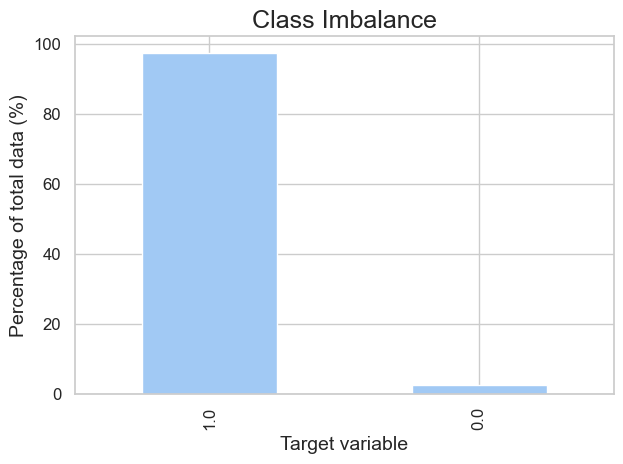

In [ ]:
df['target'].value_counts(normalize=True).apply(lambda x: round(x * 100, 2)).plot(kind='bar')
plt.title('Class Imbalance', fontsize=18)
plt.xlabel('Target variable', fontsize=14)
plt.ylabel('Percentage of total data (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('../images/class_imbalance.png', format='png')
plt.show()

Expectedly, we have a significant class imbalance against defaulted loans, which we'll need to address during preprocessing.

Notice, we can now drop the `loanStatus` column, as we've extracted & summarized all the necessary information into `target`.

We'll also choose to drop `hasCF`, since (1) we have no information on what this column represents according to the attached instructions, and (2) assuming "CF" stands for "clear fraud", one can further assume that `clearfraudscore` already holds most of the intrinsic information in `hasCF`, allowing us to safely drop it from consideration (also recall our initial assumption that the underwriting team will have rejected the majority of fraudulent applications). Though, in a real-world scenario, it'd be best to ask for clarification before doing so.

In [ ]:
# Drop irrelevant columns
df.drop(columns=['loanStatus', 'hasCF'], inplace=True)

It remains to engineer additional features out of the available data. Note the utility of taking an inventory of our current features, as to better inform the feature engineering process:

- `loan_id` & `anon_ssn` can be used to identify and track the client.
- `applicationDate` & `originatedDate` provide information on the timing of the loan.
- `loanAmount` & `apr` provide information on the cost of borrowing, which can be used to assess the affordability of the loan.
- `payFrequency` & `originallyScheduledPaymentAmount` provide information on the terms of the loan, which can be used to assess the client's ability to make regular payments.
- `nPaidOff` provides information on the client's loan repayment history, which is relevant to determining the client's trustworthiness.
- `leadType` & `leadCost` can provide information on the source & cost of obtaining the loan, which may be relevant to assessing the quality of the loan.
- `clearfraudscore` can be used to identify and flag any potential fraud.

Based on this, a potential feature could be `time_to_originate`, calculated from the difference between `application_date` & `originated_date`, in hours. This can provide information on the time it took for the loan to be originated, which may be relevant to assessing the quality of the application.

In [ ]:
# Calculate hours between applicationDate & originatedDate
df['time_to_originate'] = (df['originatedDate'] - df['applicationDate']).dt.seconds / 3600
# Display results
df

loanId                          anon_ssn  payFrequency    apr  \
0      LL-I-06644937  464f5d9ae4fa09ece4048d949191865c             1  199.0   
1      LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c             2  490.0   
2      LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc             1  590.0   
3      LL-I-09279047  1d249e27292d25e4d3b4bc142a2a4aea             0  404.1   
4      LL-I-01316580  2a10b2e04c5eec9a47a8cf5b9b81a2b8             0  590.0   
...              ...                               ...           ...    ...   
12456  LL-I-15390953  c81e355845a451b77c29b6515efa2578             1  645.0   
12457  LL-I-12367915  55392b05f72f8c3e32e5157612406ba8             1  565.0   
12458  LL-I-15280684  73690518af906288434b2a0cfd972fe0             3  645.0   
12459  LL-I-09897110  0538f828b4a0b44502ead5a8033ee779             1  449.0   
12460  LL-I-13311312  043dd86c24c63c8968082fa3ad7a8911             0  645.0   

              applicationDate          originatedDate  nPaidOff  loanAmount  \
0     2016-01-19 22:07:36.778 2016-01-20 15:49:18.846       0.0      3000.0   
1     2017-01-31 17:48:17.381 2017-01-31 18:00:14.520       2.0      1250.0   
2     2016-08-27 09:08:05.442 2016-08-29 15:05:04.014       0.0       800.0   
3     2016-05-25 03:05:18.849 2016-05-25 15:11:36.260       3.0       300.0   
4     2015-05-26 17:02:27.312 2015-05-26 18:45:48.024       0.0       300.0   
...                       ...                     ...       ...         ...   
12456 2017-01-16 04:56:31.235 2017-01-16 05:30:10.885       0.0      1500.0   
12457 2016-12-01 16:57:49.231 2016-12-01 17:28:21.872       3.0       600.0   
12458 2017-01-14 19:43:08.685 2017-01-14 20:00:10.426       0.0       375.0   
12459 2016-06-22 01:10:50.110 2016-06-22 21:46:54.359       0.0       400.0   
12460 2016-12-16 20:20:30.157 2016-12-16 23:15:06.874       0.0       300.0   

       originallyScheduledPaymentAmount  leadCost  clearfraudscore  \
0                               6395.19         0            879.0   
1                               3313.78         0            835.0   
2                               2432.08        10            624.0   
3                                422.64         0            770.0   
4                                896.87         6            693.0   
...                                 ...       ...              ...   
12456                           5111.56        25            925.0   
12457                           1670.18         0            693.0   
12458                           1042.40        25            700.0   
12459                            664.12        40            806.0   
12460                           1034.38         6            827.0   

       leadType_bvMandatory  leadType_california  leadType_express  \
0                         0                    0                 0   
1                         0                    0                 0   
2                         1                    0                 0   
3                         0                    0                 0   
4                         1                    0                 0   
...                     ...                  ...               ...   
12456                     0                    0                 0   
12457                     0                    0                 0   
12458                     0                    0                 0   
12459                     0                    0                 0   
12460                     0                    0                 0   

       leadType_instant-offer  leadType_lead  leadType_lionpay  \
0                           0              0                 0   
1                           0              0                 0   
2                           0              0                 0   
3                           0              0                 0   
4                           0              0                 0   
...                       ...         

Another useful feature is `time_since_last`, which represents the time between consecutive loan applications by a given person, in days. For non-returning clients, this value will be -1.

In [ ]:
# Create a copy of df and sort the values by ssn & applicationDate
tmp = df.sort_values(by=['anon_ssn', 'applicationDate']).copy()
# Compute the days between consecutive applications
df['time_since_last'] = tmp.groupby('anon_ssn')['applicationDate'].diff().dt.total_seconds() / (24 * 60 * 60)
# Fill NaN values
df['time_since_last'] = df['time_since_last'].fillna(-1)
# Display results
df

loanId                          anon_ssn  payFrequency    apr  \
0      LL-I-06644937  464f5d9ae4fa09ece4048d949191865c             1  199.0   
1      LL-I-16519347  bc9fa73468acf18cb968a3a6a3c4697c             2  490.0   
2      LL-I-11506719  10cefd11d41612b032fd9cd2debe32dc             1  590.0   
3      LL-I-09279047  1d249e27292d25e4d3b4bc142a2a4aea             0  404.1   
4      LL-I-01316580  2a10b2e04c5eec9a47a8cf5b9b81a2b8             0  590.0   
...              ...                               ...           ...    ...   
12456  LL-I-15390953  c81e355845a451b77c29b6515efa2578             1  645.0   
12457  LL-I-12367915  55392b05f72f8c3e32e5157612406ba8             1  565.0   
12458  LL-I-15280684  73690518af906288434b2a0cfd972fe0             3  645.0   
12459  LL-I-09897110  0538f828b4a0b44502ead5a8033ee779             1  449.0   
12460  LL-I-13311312  043dd86c24c63c8968082fa3ad7a8911             0  645.0   

              applicationDate          originatedDate  nPaidOff  loanAmount  \
0     2016-01-19 22:07:36.778 2016-01-20 15:49:18.846       0.0      3000.0   
1     2017-01-31 17:48:17.381 2017-01-31 18:00:14.520       2.0      1250.0   
2     2016-08-27 09:08:05.442 2016-08-29 15:05:04.014       0.0       800.0   
3     2016-05-25 03:05:18.849 2016-05-25 15:11:36.260       3.0       300.0   
4     2015-05-26 17:02:27.312 2015-05-26 18:45:48.024       0.0       300.0   
...                       ...                     ...       ...         ...   
12456 2017-01-16 04:56:31.235 2017-01-16 05:30:10.885       0.0      1500.0   
12457 2016-12-01 16:57:49.231 2016-12-01 17:28:21.872       3.0       600.0   
12458 2017-01-14 19:43:08.685 2017-01-14 20:00:10.426       0.0       375.0   
12459 2016-06-22 01:10:50.110 2016-06-22 21:46:54.359       0.0       400.0   
12460 2016-12-16 20:20:30.157 2016-12-16 23:15:06.874       0.0       300.0   

       originallyScheduledPaymentAmount  leadCost  clearfraudscore  \
0                               6395.19         0            879.0   
1                               3313.78         0            835.0   
2                               2432.08        10            624.0   
3                                422.64         0            770.0   
4                                896.87         6            693.0   
...                                 ...       ...              ...   
12456                           5111.56        25            925.0   
12457                           1670.18         0            693.0   
12458                           1042.40        25            700.0   
12459                            664.12        40            806.0   
12460                           1034.38         6            827.0   

       leadType_bvMandatory  leadType_california  leadType_express  \
0                         0                    0                 0   
1                         0                    0                 0   
2                         1                    0                 0   
3                         0                    0                 0   
4                         1                    0                 0   
...                     ...                  ...               ...   
12456                     0                    0                 0   
12457                     0                    0                 0   
12458                     0                    0                 0   
12459                     0                    0                 0   
12460                     0                    0                 0   

       leadType_instant-offer  leadType_lead  leadType_lionpay  \
0                           0              0                 0   
1                           0              0                 0   
2                           0              0                 0   
3                           0              0                 0   
4                           0              0                 0   
...                       ...         

One could also choose a feature like `num_previous_funded_loans`, indicating how many previously funded loans a client has had with MoneyLion in the past, at the time of the application. Though, upon closer inspection, we notice there are some missing entries.

For example, the following client is missing loans #0, #6, #10, and #14.

In [ ]:
# Note: this ssn has the most entries on-file
df[df['anon_ssn'] == '228060b9cc8af6a937d0321122d459f3'].sort_values(by=['applicationDate'])

loanId                          anon_ssn  payFrequency     apr  \
11296  LL-I-04012560  228060b9cc8af6a937d0321122d459f3             1  449.99   
3067   LL-I-04358754  228060b9cc8af6a937d0321122d459f3             1  449.99   
4506   LL-I-05205561  228060b9cc8af6a937d0321122d459f3             1  449.99   
3101   LL-I-06837849  228060b9cc8af6a937d0321122d459f3             1  449.99   
1012   LL-I-08384112  228060b9cc8af6a937d0321122d459f3             1  449.99   
10786  LL-I-09327212  228060b9cc8af6a937d0321122d459f3             1  404.10   
9159   LL-I-10053275  228060b9cc8af6a937d0321122d459f3             1  404.10   
4292   LL-I-10680938  228060b9cc8af6a937d0321122d459f3             1  449.99   
5282   LL-I-11629173  228060b9cc8af6a937d0321122d459f3             1  449.99   
7016   LL-I-12081344  228060b9cc8af6a937d0321122d459f3             1  449.99   
3594   LL-I-12120038  228060b9cc8af6a937d0321122d459f3             1  449.99   
1722   LL-I-16760104  228060b9cc8af6a937d0321122d459f3             1  449.99   

              applicationDate          originatedDate  nPaidOff  loanAmount  \
11296 2015-10-23 14:56:26.973 2015-10-23 15:41:41.837       1.0       800.0   
3067  2015-11-05 19:28:54.692 2015-11-05 19:47:35.596       2.0       800.0   
4506  2015-12-01 21:44:50.958 2015-12-02 15:22:55.320       3.0       800.0   
3101  2016-01-27 16:52:33.451 2016-01-27 18:07:50.283       4.0       800.0   
1012  2016-04-04 14:07:52.556 2016-04-05 18:18:39.840       5.0       800.0   
10786 2016-05-26 19:57:32.706 2016-05-26 21:23:45.516       7.0       600.0   
9159  2016-06-30 15:14:52.727 2016-06-30 19:08:44.701       8.0       400.0   
4292  2016-07-30 20:19:50.936 2016-07-31 16:11:46.279       9.0      1000.0   
5282  2016-08-31 02:54:39.904 2016-08-31 15:02:27.824      11.0      1000.0   
7016  2016-09-28 15:53:32.914 2016-09-28 20:07:49.891      12.0      1000.0   
3594  2016-11-05 16:24:17.676 2016-11-07 23:06:08.769      13.0      1000.0   
1722  2017-02-06 10:12:49.225 2017-02-06 10:30:14.234      15.0       400.0   

       originallyScheduledPaymentAmount  leadCost  clearfraudscore  \
11296                           1722.75         0            614.0   
3067                            1318.06         0            614.0   
4506                            1389.67         0            693.0   
3101                            1359.82         0            614.0   
1012                            1449.38         0            614.0   
10786                            957.95         0            614.0   
9159                             692.24         0            614.0   
4292                            1811.70         0            752.0   
5282                            2051.77         0            752.0   
7016                            1664.27         0            752.0   
3594                            2640.41         0            752.0   
1722                            1048.73         0            693.0   

       leadType_bvMandatory  leadType_california  leadType_express  \
11296                     0                    0                 0   
3067                      0                    0                 0   
4506                      0                    0                 0   
3101                      0                    0                 0   
1012                      0                    0                 0   
10786                     0                    0                 0   
9159                      0                    0                 0   
4292                      0                    0                 0   
5282                      0                    0                 0   
7016                      0                    0                 0   
3594                      0                    0                 0   
1722                      0                    0                 0   

       leadType_instant-offer  leadType_lead  leadType_lionpay  \
11296                       0              0             

More explicitly, create a temporary column `loan_count` with the values one would expect without prior knowledge about the missing entries, and juxtapose it with `nPaidOff`.

In [ ]:
# Count the number of distinct loan IDs up to (& excluding) the current application date
tmp = df.copy()
tmp = tmp.sort_values(by=['anon_ssn', 'applicationDate'])
tmp['loan_count'] = tmp.groupby(['anon_ssn'])['loanId'].cumcount()
tmp[tmp['anon_ssn'] == '228060b9cc8af6a937d0321122d459f3'][['anon_ssn', 'loanId','nPaidOff', 'loan_count']]

anon_ssn         loanId  nPaidOff  loan_count
11296  228060b9cc8af6a937d0321122d459f3  LL-I-04012560       1.0           0
3067   228060b9cc8af6a937d0321122d459f3  LL-I-04358754       2.0           1
4506   228060b9cc8af6a937d0321122d459f3  LL-I-05205561       3.0           2
3101   228060b9cc8af6a937d0321122d459f3  LL-I-06837849       4.0           3
1012   228060b9cc8af6a937d0321122d459f3  LL-I-08384112       5.0           4
10786  228060b9cc8af6a937d0321122d459f3  LL-I-09327212       7.0           5
9159   228060b9cc8af6a937d0321122d459f3  LL-I-10053275       8.0           6
4292   228060b9cc8af6a937d0321122d459f3  LL-I-10680938       9.0           7
5282   228060b9cc8af6a937d0321122d459f3  LL-I-11629173      11.0           8
7016   228060b9cc8af6a937d0321122d459f3  LL-I-12081344      12.0           9
3594   228060b9cc8af6a937d0321122d459f3  LL-I-12120038      13.0          10
1722   228060b9cc8af6a937d0321122d459f3  LL-I-16760104      15.0          11

Thus, due to the discrepancy, we'll refrain from using `num_previous_funded_loans` as a feature.

In fact, in the interest of time, we'll assume our currently implemented features will suffice. For further discussion regarding potential new data/features, see the "Further Work" section.

## 2.5 Data Visualization

Finally, we visualize the data to better inform the model development process. First, we generate descriptive statistics for the numeric features.

In [ ]:
# Make a copy for exploratory analysis/visualization
data = df.copy()
# Print descriptive stats for numeric columns
data[['apr', 'nPaidOff', 'loanAmount', 'originallyScheduledPaymentAmount', 'leadCost', 'clearfraudscore', 'time_to_originate', 'time_since_last']].describe()

apr      nPaidOff    loanAmount  \
count  12461.000000  12461.000000  12461.000000   
mean     508.946662      0.590081    629.297007   
std      117.319897      1.389716    451.761168   
min        0.000000      0.000000    100.000000   
25%      390.000000      0.000000    350.000000   
50%      565.000000      0.000000    500.000000   
75%      590.000000      1.000000    700.000000   
max      705.590000     21.000000   4687.000000   

       originallyScheduledPaymentAmount      leadCost  clearfraudscore  \
count                      12461.000000  12461.000000     12461.000000   
mean                        1661.688210     12.109863       709.577482   
std                         1202.830803     24.749500       115.983220   
min                          188.410000      0.000000       177.000000   
25%                          950.230000      0.000000       655.000000   
50%                         1303.620000      3.000000       693.000000   
75%                         1943.700000     10.000000       794.000000   
max                        12550.080000    200.000000       961.000000   

       time_to_originate  time_since_last  
count       12461.000000     12461.000000  
mean            7.040876        26.693385  
std             7.638825        72.233430  
min             0.000000        -1.000000  
25%             0.715000        -1.000000  
50%             3.221111        -1.000000  
75%            13.698611        -1.000000  
max            23.998333       608.884541

Already, we see that the average funded loan at MoneyLion is for $629.30 in principal, at an APR of 5.089% (assuming the data are expressed in basis points), with an expected payment amount of $1661.69. Additionally, the average funded loan application takes 7.04 days to originate, and receives a clear fraud score of 709.58 from the underwriting team.

However, without prior knowledge of how these data are distributed, it's difficult to tell how useful these statistics truly are.

Subsequently, we move on to the features concerning the terms of the loans.

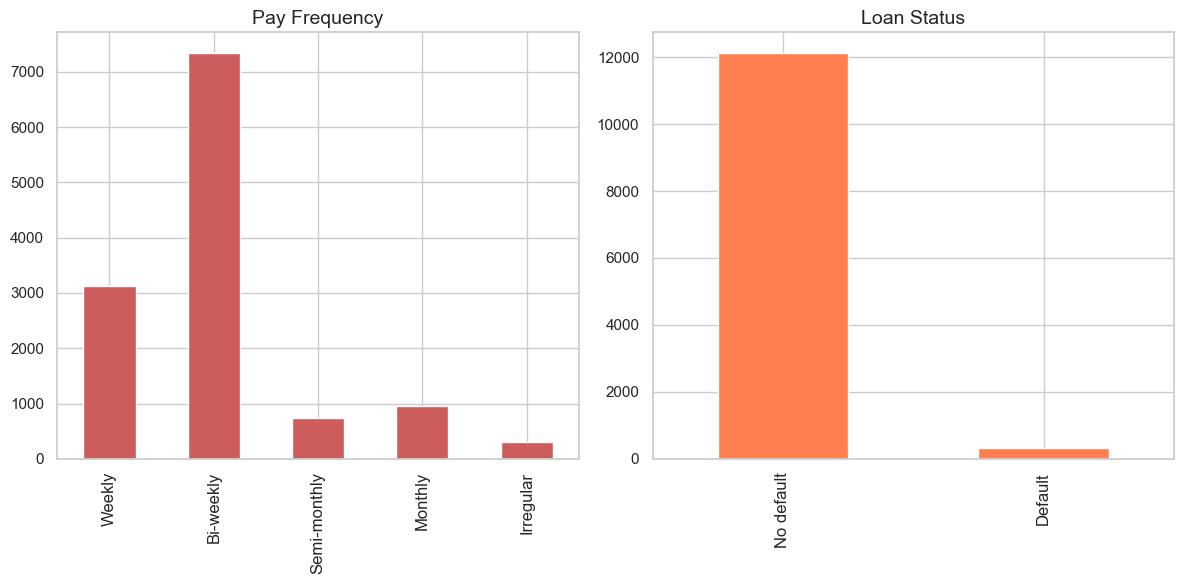

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

data.groupby(['payFrequency']).size().plot(kind='bar', color='indianred', ax=ax[0])
ax[0].set_title('Pay Frequency', fontsize=14)
ax[0].set_xlabel('')
ax[0].set_xticks(range(len(['Weekly', 'Bi-weekly', 'Semi-monthly', 'Monthly', 'Irregular'])))
ax[0].set_xticklabels(['Weekly', 'Bi-weekly', 'Semi-monthly', 'Monthly', 'Irregular'], fontsize=12)

data['target'].value_counts().plot(kind='bar', color='coral', ax=ax[1])
ax[1].set_title('Loan Status', fontsize=14)
ax[1].set_xlabel('')
ax[1].set_xticklabels(['No default', 'Default'], fontsize=12)

plt.tight_layout()
plt.savefig('../images/loan_details.png', format='png')
plt.show()

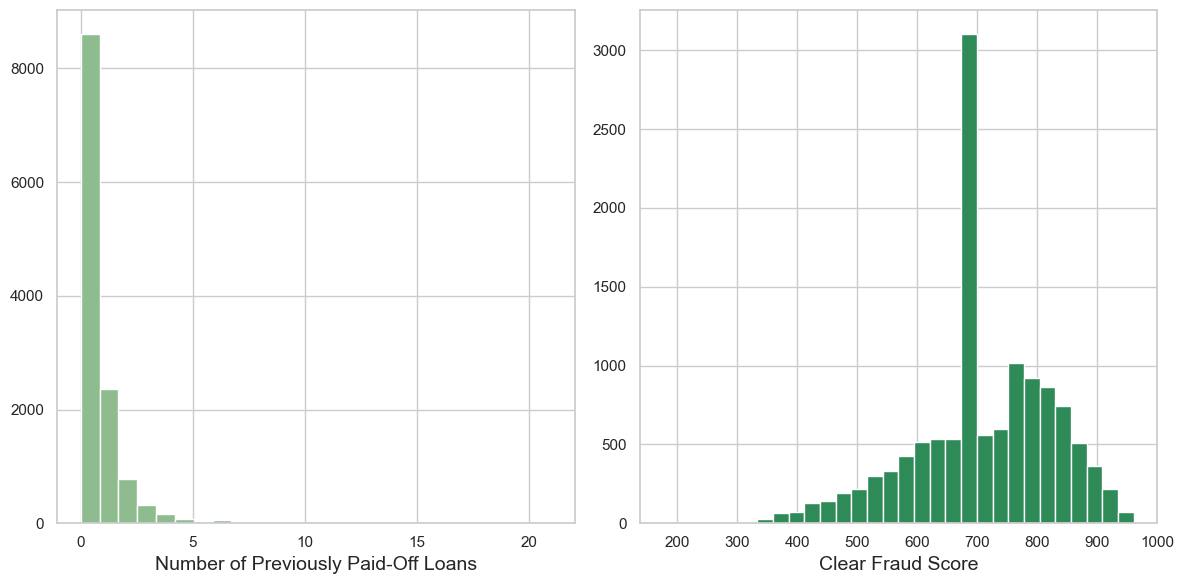

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

data['nPaidOff'].plot(kind='hist', bins=25, color='darkseagreen', ax=ax[0])
data['clearfraudscore'].plot(kind='hist', bins=30, color='seagreen', ax=ax[1])

ax[0].set_xlabel('Number of Previously Paid-Off Loans', fontsize=14)
ax[0].set_ylabel('')

ax[1].set_xlabel('Clear Fraud Score', fontsize=14)
ax[1].set_ylabel('')

plt.tight_layout()
plt.savefig('../images/client_trustworthiness.png', format='png')
plt.show()

We notice the majority of funded loan applications follow either a weekly or bi-weekly repayment schedule.

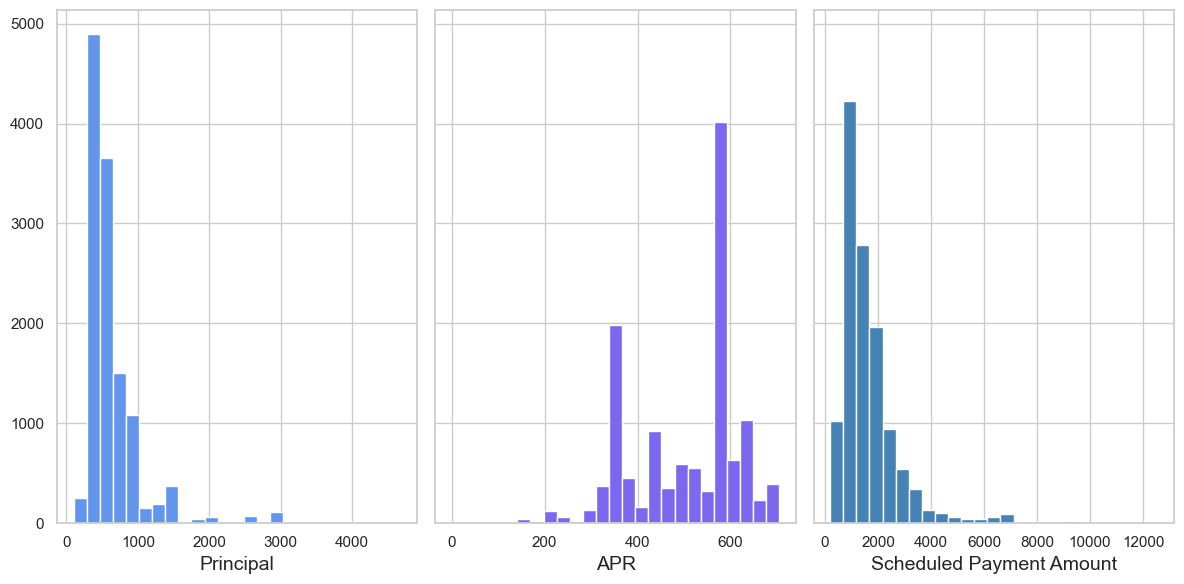

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

data['loanAmount'].plot(kind='hist', bins=25, color='cornflowerblue', ax=ax[0])
data['apr'].plot(kind='hist', bins=25, color='mediumslateblue', ax=ax[1])
data['originallyScheduledPaymentAmount'].plot(kind='hist', bins=25, color='steelblue', ax=ax[2])

ax[0].set_xlabel('Principal', fontsize=14)
ax[0].set_ylabel('')
ax[1].set_xlabel('APR', fontsize=14)
ax[2].set_xlabel('Scheduled Payment Amount', fontsize=14)

plt.tight_layout()
plt.savefig('../images/cost_of_borrowing.png', format='png')
plt.show()

Interestingly, all 3 columns containing the financial terms of the loan are heavily skewed. Since these features are undoubtably important to the task at hand, we should either pick a model that's robust to skewness, or normalize these data during preprocessing.

Next, we tackle the features relating to time-components of the loan application, where if there are any noteworthy trends, we may consider extracting additional features from the data.

In [ ]:
# Perform aggregations
data['application_year'] = data['applicationDate'].dt.year
data['application_month'] = data['applicationDate'].dt.month
data['application_day'] = data['applicationDate'].dt.day
data['application_day_of_week'] = data['applicationDate'].dt.day_of_week
data['application_quarter'] = data['applicationDate'].dt.quarter

days = {0: 'M', 1: 'T', 2: 'W', 3: 'R', 4: 'F', 5: 'S', 6: 'SS'}
data['application_day_of_week'] = data['application_day_of_week'].map(days)

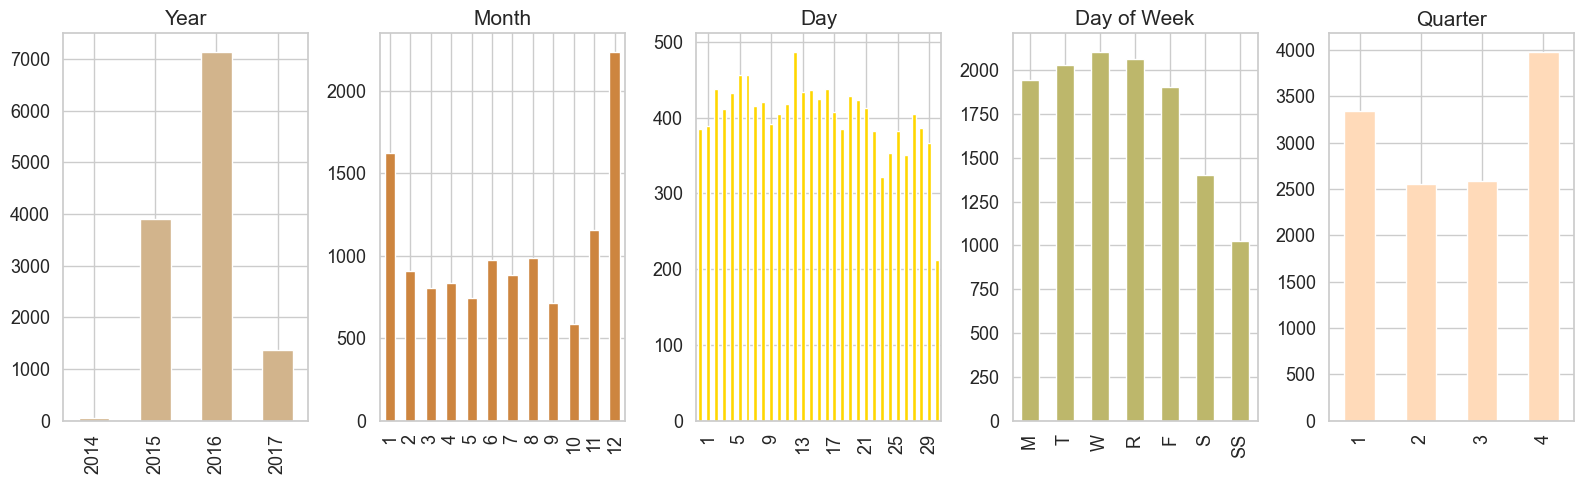

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(16, 5))

data.groupby(['application_year']).size().plot(kind='bar', color='tan', ax=ax[0])
data.groupby(['application_month']).size().plot(kind='bar', color='peru', ax=ax[1])
data.groupby(['application_day']).size().plot(kind='bar', xticks=range(1, 31, 4), color='gold', ax=ax[2])
data.groupby(['application_day_of_week']).size().reindex(['M', 'T', 'W', 'R', 'F', 'S', 'SS']).plot(kind='bar', color='darkkhaki', ax=ax[3])
data.groupby(['application_quarter']).size().plot(kind='bar', color='peachpuff', ax=ax[4])

ax[0].set_title('Year', fontsize=15)
ax[0].set_xlabel('')
ax[1].set_title('Month', fontsize=15)
ax[1].set_xlabel('')
ax[2].set_title('Day', fontsize=15)
ax[2].set_xlabel('')
ax[3].set_title('Day of Week', fontsize=15)
ax[3].set_xlabel('')
ax[4].set_title('Quarter', fontsize=15)
ax[4].set_xlabel('')

for i in range(5):
    ax[i].tick_params(axis='both', which='both', labelsize=13)

plt.tight_layout()
plt.savefig('../images/application_trends.png', format='png')
plt.show()

From here, we have the following takeaways:
1. Since the data from 2014 & 2017 are incomplete, we derive that MoneyLion funded roughly 1.75x more loans from 2016 vs 2015.
2. The number of loan applications are concentrated near December & January, most likely as a result of the holiday season. Naturally, MoneyLion funds the most loans during Q1 & Q4.
3. MoneyLion funds less loans whose applications were received on weekends compared to weekdays (most likely explanation: less people submit loan applications on weekends).

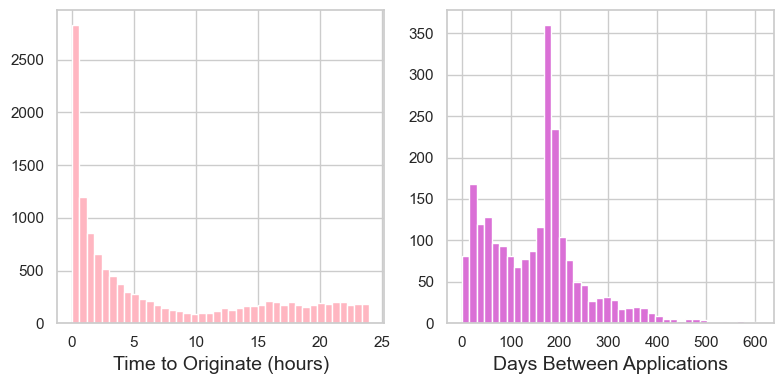

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

data['time_to_originate'].plot(kind='hist', bins=40, color='lightpink', ax=ax[0])
# Exclude non-returning applications
data[data['time_since_last'] >= 0]['time_since_last'].plot(kind='hist', bins=40, color='orchid', ax=ax[1])

ax[0].set_xlabel('Time to Originate (hours)', fontsize=14)
ax[0].set_ylabel('')
ax[1].set_xlabel('Days Between Applications', fontsize=14)
ax[1].set_ylabel('')

plt.tight_layout()
plt.savefig('../images/turnover_rates.png', format='png')
plt.show()

We find that most loan applications are originated within a few hours, and most returning clients submit another successful application roughly 200 days after their last. Notice, again, the skewness in both distributions, which, again, is something we must address either during preprocessing or model selection.

Finally, we visualize the correlations between features via a heatmap.

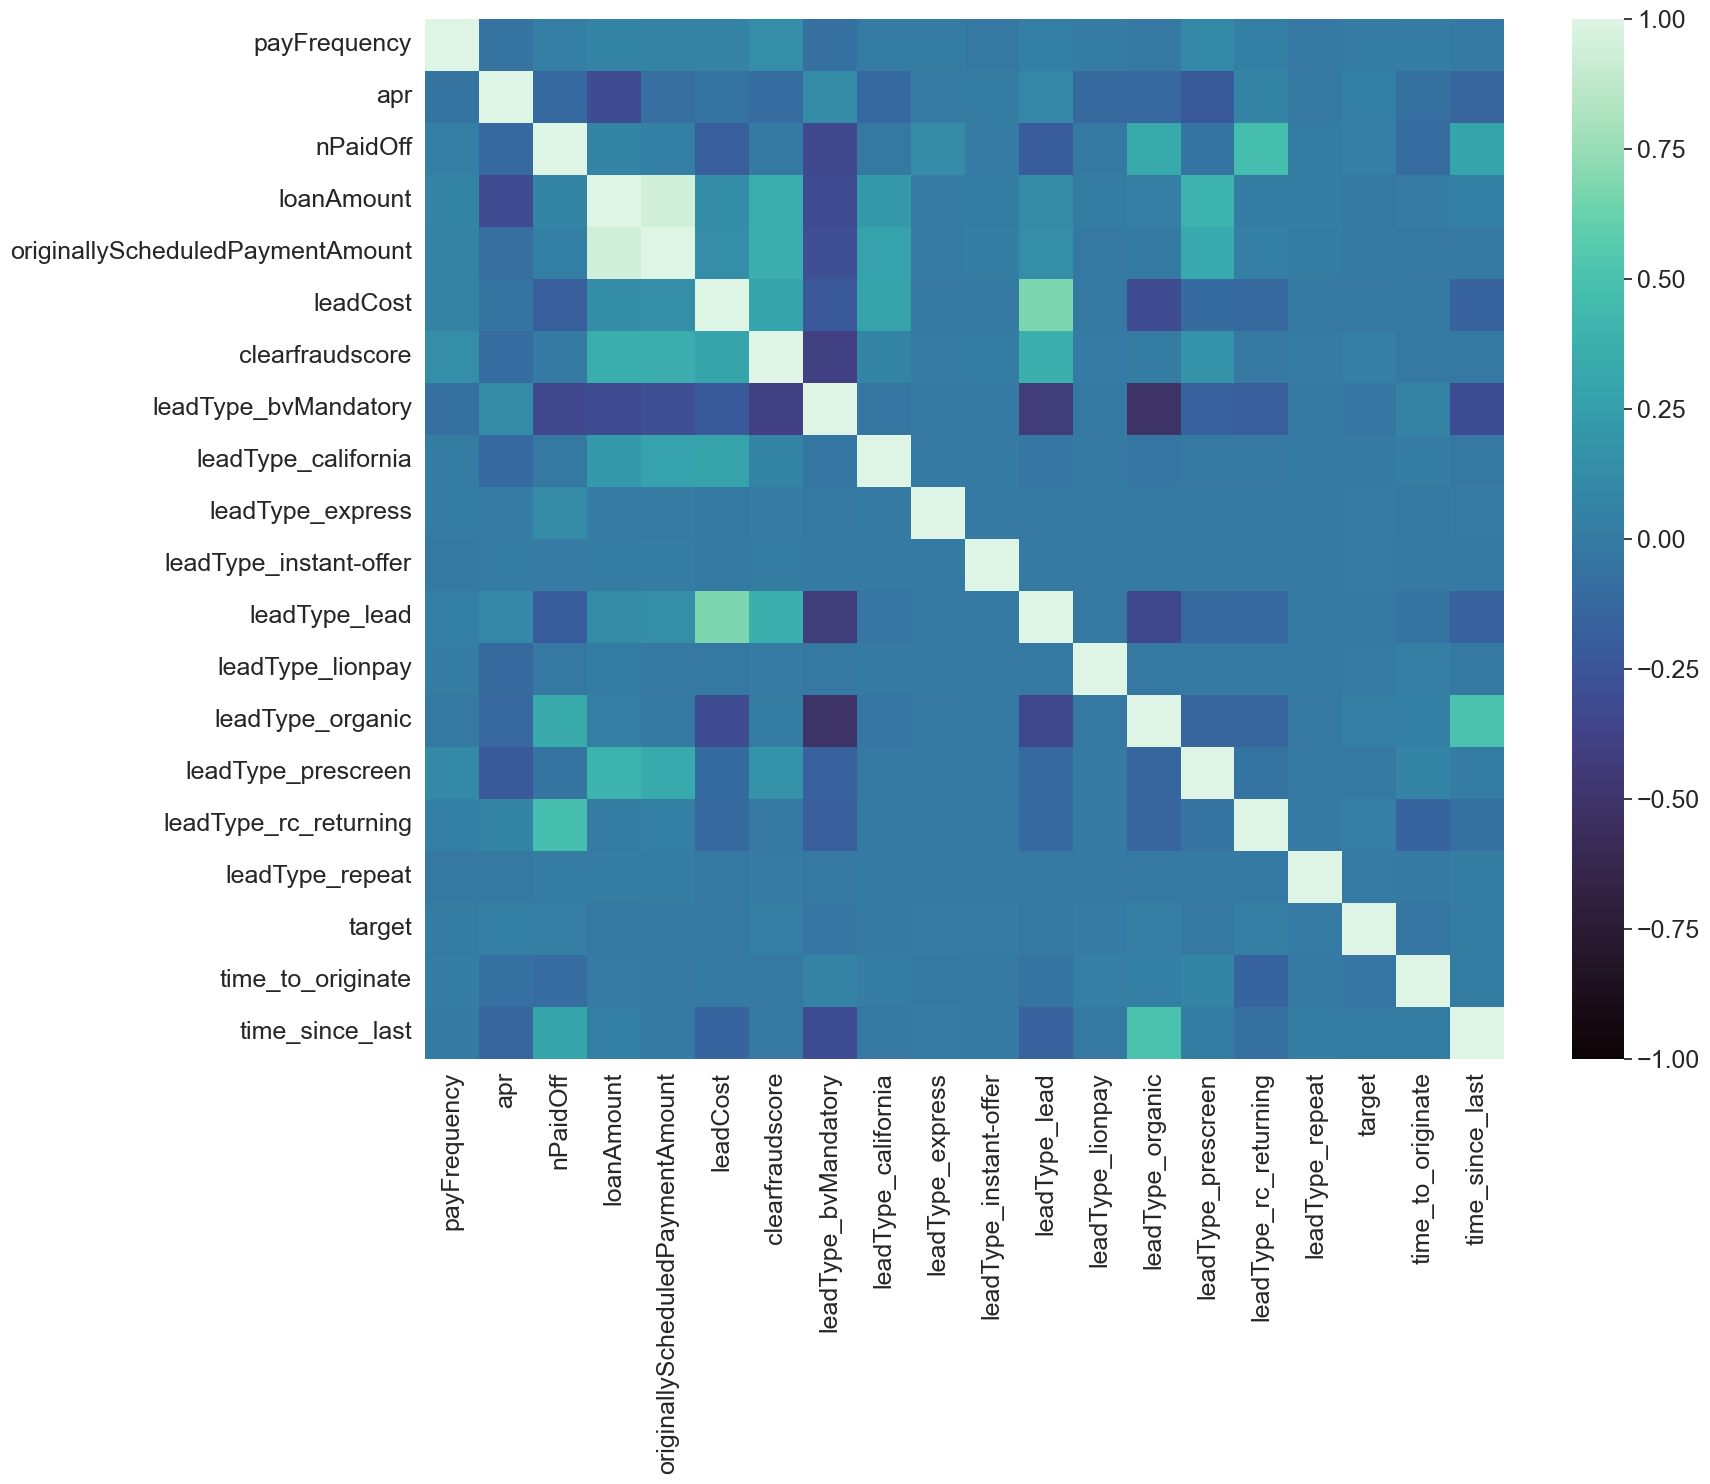

In [ ]:
plt.figure(figsize=(18, 15))
corr_heatmap = sns.heatmap(df.corr(), vmin=-1.0, cmap='mako', annot_kws={"fontsize": 13})

corr_heatmap.set_xticklabels(corr_heatmap.get_xticklabels(), fontsize=18)
corr_heatmap.set_yticklabels(corr_heatmap.get_yticklabels(), fontsize=18)
cbar = corr_heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.savefig('../images/correlation_heatmap.png', format='png')
plt.show()

Ending with the following key insights:
- `target` is not significantly correlated with any of the features.
- The only relevant highly correlated features are `loanAmount` & `originallyScheduledPaymentAmount` (0.94); nothing to worry about yet, though if our model ends up generating unreliable/unstable predictions, it may be due to multicolinearity. In which case, we'll simply circle back & drop one of the two features.

# 3. Preprocessing

Now that we have a good grasp of the data, we can begin preparing it for training.

We start by dropping `applicationDate` & `originatedDate` from our list of features, with the justifications that (1) there are no clear & obvious trends in the application/originated dates, (2) there is no reason to believe these dates on their own can indicate the outcome of a loan, and (3) we've already aggregated the time-contextual data into `time_to_originate` and `time_since_last`.

In [ ]:
# Drop irrelevant columns
df.drop(columns=['applicationDate', 'originatedDate'], inplace=True)

## 3.1 Scaling/Normalization

Next, to prevent any one feature from dominating the others, we perform scaling/normalization on the numeric features (excluding binary & one-hot encoded features). More specifically, we apply

- min-max scaling to the features containing outliers (`loanAmount`, `originallyScheduledPaymentAmount`)
- z-score standardization on the features whose Gaussianity we want to preserve (`clearfraudscore`)
- box-cox transformation to the positively skewed features (`nPaidOff`, `time_to_originate`, `leadCost`)
- logarithmic transform on the features with bimodal distributions (`apr`, `time_since_last`)

Note that because `time_since_last` uses -1 inplace of `NaN` values, we'll only normalize the positive values in the column.

In [ ]:
# Min-max scaling
scaler = MinMaxScaler()
df[['loanAmount', 'originallyScheduledPaymentAmount']] = scaler.fit_transform(df[['loanAmount', 'originallyScheduledPaymentAmount']])

# Z-score standardization
mean, stdev = df['clearfraudscore'].mean(), df['clearfraudscore'].std()
df['clearfraudscore'] = (df['clearfraudscore'] - mean) / stdev

# Box-cox transformation
cols = ['nPaidOff', 'time_to_originate', 'leadCost']
for col in cols:
    df[col], _ = boxcox(df[col] + 1)

# Logarithmic transform
df['apr'] = np.log(df['apr'])
mask = df['time_since_last'] >= 0
df.loc[mask, 'time_since_last'] = np.log(df.loc[mask, 'time_since_last'])

From the above RuntimeWarning, we uncover that the application with loan ID `LL-I-00526002` had an APR of 0 to begin with, leading to an `-inf` value post-log transform. Similarly, the client with SSN `7edc6acb596c64104d96b3d6897d2aed` made 2 simultaneous applications on `2015-02-20 17:16:24.718`, both of which were also originated simultaneously on `2015-02-20 19:40:33.329`, implying a `time_since_last` value of 0 (and a post-log transform value of `-inf`).

In [ ]:
# Initial APR: 0 -> APR after normalization: -Inf
df.iloc[[9299, 10086]]

loanId                          anon_ssn  payFrequency  \
9299   LL-I-00526002  7996ea34884d235f656e25d9df4e8bc3             1   
10086  LL-I-00260783  7edc6acb596c64104d96b3d6897d2aed             1   

            apr  nPaidOff  loanAmount  originallyScheduledPaymentAmount  \
9299       -inf       0.0    0.152605                          0.049475   
10086  6.380123       0.0    0.087203                          0.104839   

       leadCost  clearfraudscore  leadType_bvMandatory  leadType_california  \
9299    1.19243         -0.14293                     1                    0   
10086   0.00000         -0.14293                     0                    0   

       leadType_express  leadType_instant-offer  leadType_lead  \
9299                  0                       0              0   
10086                 0                       0              0   

       leadType_lionpay  leadType_organic  leadType_prescreen  \
9299                  0                 0                   0   
10086                 0                 1                   0   

       leadType_rc_returning  leadType_repeat  target  time_to_originate  \
9299                       0                0     1.0           2.633038   
10086                      0                0     1.0           1.151735   

       time_since_last  
9299              -1.0  
10086             -inf

Since both datapoints contain questionable logic, we'll drop them from the dataframe.

In [ ]:
# Drop problematic row
df = df.drop(index=[9299, 10086]).reset_index(drop=True)

Finally, we perform a sanity check on the normalized features to make sure nothing went wrong.

In [ ]:
# Specify the normalized features
features = ['loanAmount', 'originallyScheduledPaymentAmount', 'apr', 'time_since_last', 'clearfraudscore', 'nPaidOff', 'leadCost', 'time_to_originate']
# Print descriptive statistics
df[features].describe()

loanAmount  originallyScheduledPaymentAmount           apr  \
count  12459.000000                      12459.000000  12459.000000   
mean       0.115390                          0.119188      6.199059   
std        0.098494                          0.097309      0.279674   
min        0.000000                          0.000000      3.400864   
25%        0.054502                          0.061632      5.966147   
50%        0.087203                          0.090215      6.336826   
75%        0.130804                          0.141995      6.380123   
max        1.000000                          1.000000      6.559034   

       time_since_last  clearfraudscore      nPaidOff      leadCost  \
count     12459.000000     12459.000000  12459.000000  12459.000000   
mean          0.030695         0.000023      0.108273      1.112824   
std           2.235745         1.000079      0.162160      0.975076   
min          -1.000000        -4.591849      0.000000      0.000000   
25%          -1.000000        -0.470564      0.000000      0.000000   
50%          -1.000000        -0.142930      0.000000      1.192430   
75%          -1.000000         0.727886      0.328587      1.857130   
max           6.411629         2.167749      0.398473      3.109518   

       time_to_originate  
count       12459.000000  
mean            1.395926  
std             0.905248  
min             0.000000  
25%             0.524981  
50%             1.340252  
75%             2.353771  
max             2.747909

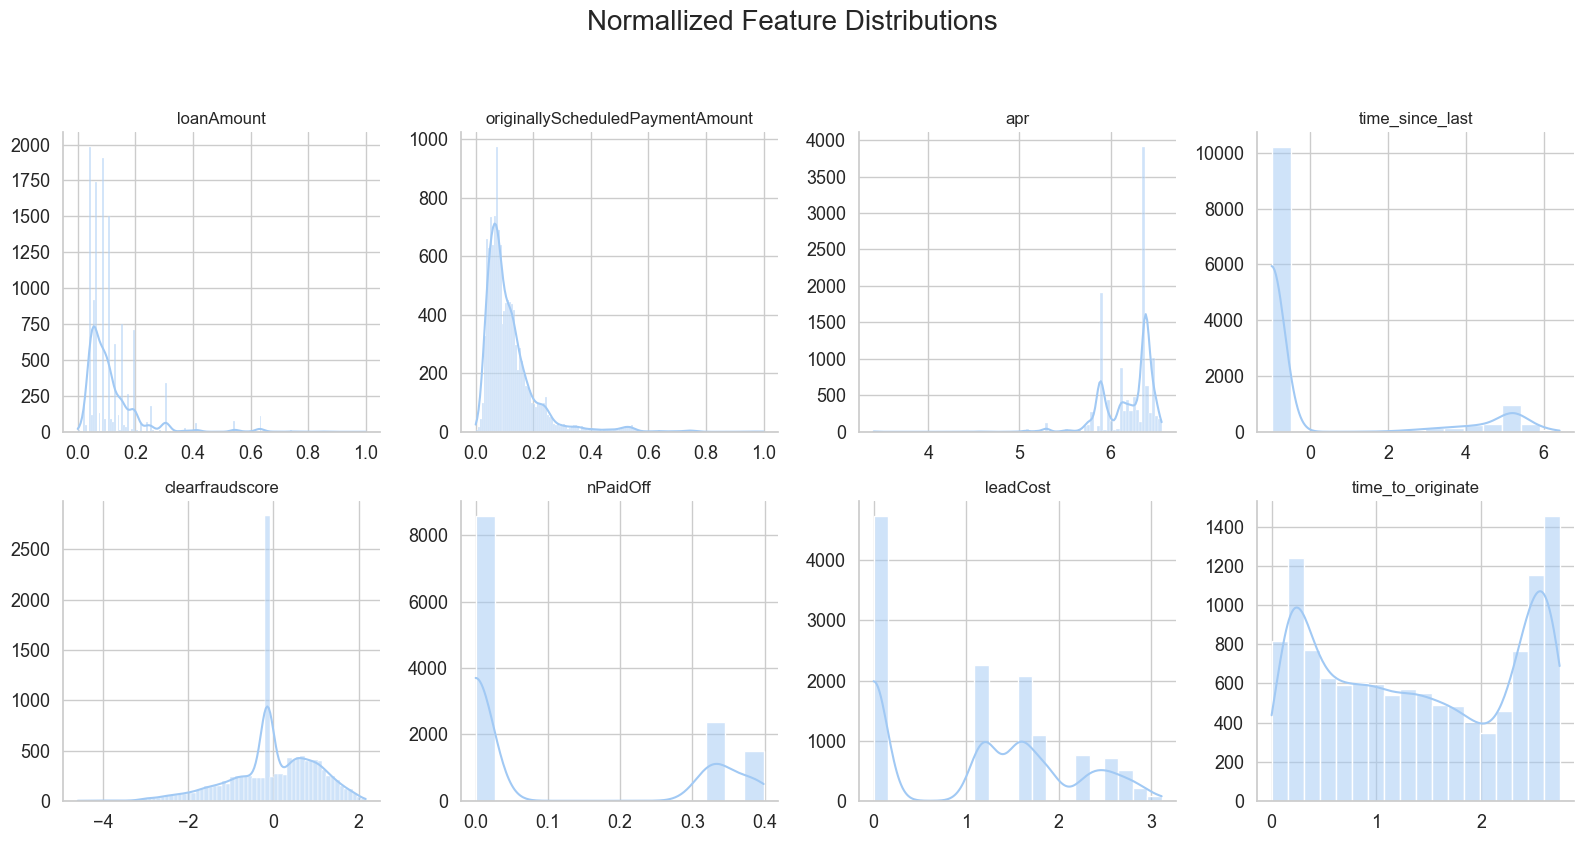

In [ ]:
df_pivot = df[features].melt(var_name='variable', value_name='value')
g = sns.FacetGrid(df_pivot, col='variable', col_wrap=4, height=4, sharex=False, sharey=False)
g = g.map(sns.histplot, 'value', bins='auto', kde=True)

g.set_titles('{col_name}', fontsize=16)
g.set(xlabel='', ylabel='')
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), fontsize=13)
    plt.setp(ax.get_yticklabels(), fontsize=13)

plt.suptitle('Normallized Feature Distributions', fontsize=20, y=1.05)
g.tight_layout()
plt.savefig('../images/normalized_feature_distributions.png', format='png')
plt.show()

Notice:
- features with min-max scaling (`loanAmount`, `originallyScheduledPaymentAmount`) are now nicely distributed over the interval [0, 1].
- features with z-score standardization (`clearfraudscore`) remain Gaussian with a mean close to 0 and standard deviation near 1.
- features with box-cox transformation (`nPaidOff`, `time_to_originate`, `leadCost`) have improved Gaussianity (more symmetrical distributions) with reduced skewness.
- features with logarithmic transform (`apr`; we'll address `time_since_last` shortly) appear more Gaussian-like with less skewness than before.

All in all, no significant deviations in the features' distributions w.r.t. our expectations! Only thing of note is the histogram of `time_since_last`, as since we only normalized the positive values, it'd be more useful to visualize the distribution of these data instead.

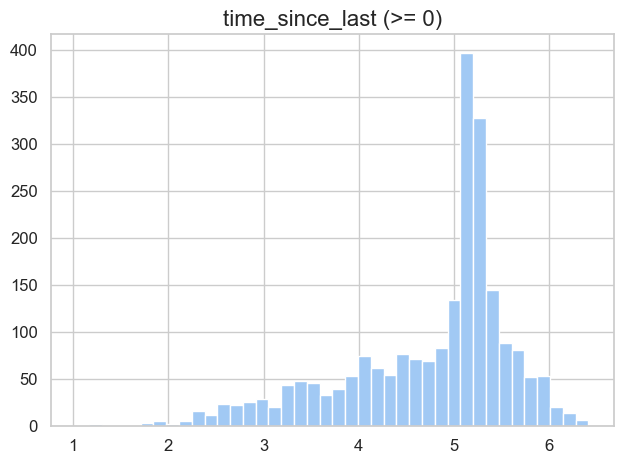

In [ ]:
df[df['time_since_last'] >= 0]['time_since_last'].plot(kind='hist', bins=40)
plt.title('time_since_last (>= 0)', fontsize=16)
plt.ylabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('../images/normalized_feature_distributions_correction.png', format='png')
plt.show()

Indeed, the data appear much better than before!

## 3.2 Class Imbalance

Subsequently, we address the issue of class imbalance via oversampling.

In [ ]:
# Separate the unique identifiers & target variable from the features
X, y = df.drop(['loanId', 'anon_ssn', 'target'], axis=1), df['target']

# Check the class distribution before balancing
print(f'Class distribution before balancing: \n{y.value_counts(normalize=True).apply(lambda x: f"{x * 100:.2f}%")}\n')

# Balance the class distribution using oversampling
ros = RandomOverSampler(random_state=11)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Check the class distribution after balancing
print(f'Class distribution after balancing: \n{y_resampled.value_counts(normalize=True).apply(lambda x: f"{x * 100:.2f}%")}\n')


Class distribution before balancing: 
1.0    97.38%
0.0     2.62%
Name: target, dtype: object

Class distribution after balancing: 
1.0    50.00%
0.0    50.00%
Name: target, dtype: object



## 3.3 Train-Test Split

Finally, we split the resampled data into train and test sets using an 80/20 split.

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=11)

# 4. Model Development

Moving onto the model development phase, we'll experiment with a couple different models, and fine-tune the best performing one. Note that our models should be robust to skewness, based on our findings in previous sections. Also, due to the class imbalance, we'll evaluate each model's performance using ROC-AUC score, rather than accuracy.

## 4.1 Training

We proceed with the following popular binary classification models:

- Logistic regression
- Support Vector Machine
- Random Forest Ensemble
- Multi-Layer Perceptron (Neural Net)

More specifically, we train each model on the data in `X_train` & `y_train`, and evaluate each model's performance on `X_test` & `y_test` using their ROC-AUC score (expressed as a percentage).

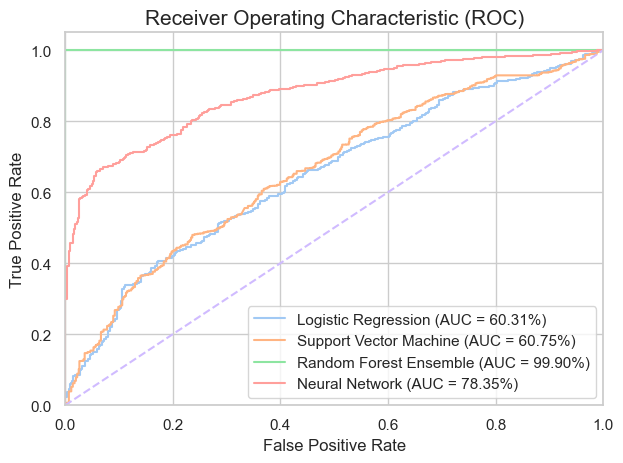

In [ ]:
# Initialize models
models = {'Logistic Regression': LogisticRegression(max_iter=1000,
                                                    n_jobs=-1,
                                                    random_state=11),
          'Support Vector Machine': SVC(probability=True,
                                        random_state=11),
          'Random Forest Ensemble': RandomForestClassifier(n_jobs=-1,
                                                           random_state=11),
          'Neural Network': MLPClassifier(max_iter=1000,
                                          random_state=11)}
for name, model in models.items():
    # Fit models to train
    model.fit(X_train, y_train)
    # Calculate the false-positive & true-positive rates, and the decision threshold
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    # Plot the resulting ROC graph & calculate AUC
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, model.predict(X_test)) * 100:.2f}%)')
# Customize ROC graph
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)', fontsize=15)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('../images/roc_auc.png', format='png')
plt.show()

## 4.2 Model Selection

Incredibly, the Random Forest Ensemble vastly outperforms the other 3 models, with an ROC-AUC score of 99.90%!

As such, it will be our model of choice for the task at hand.

## 4.3 Fine-Tuning

Additionally, since the model performed so well at identifying loans at risk of default, we'll skip the fine-tuning phase altogether, as any incremental improvement in performance would not be worth the additional time spent + computational costs (not to mention the potential for overfitting). Though, this logic would not apply in a real-world setting, due to the potential business impacts of the given assignment.

## 4.4 Model Evaluation

It remains to evaluate the model to gain a deeper understanding of what's happening "under the hood". We can do so by visualizing the feature importances of the trees in the forest, to see which features are most/least important for the model to arrive at the right answer.

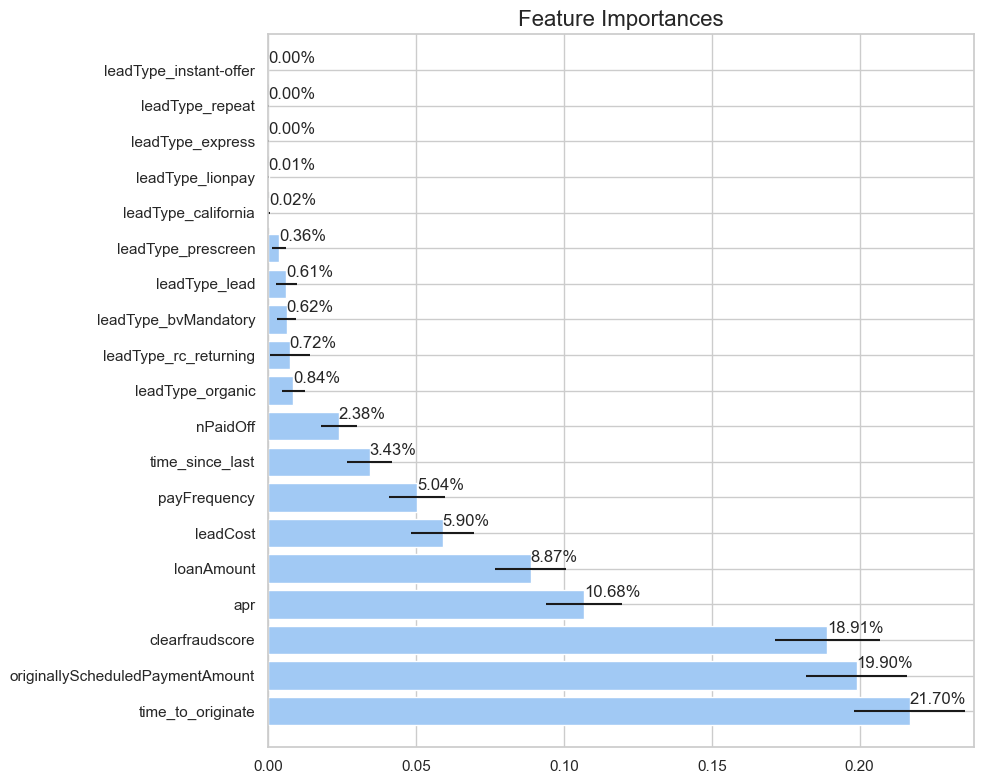

In [ ]:
clf = models['Random Forest Ensemble']

# Plot feature importances
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(10, 8))
plt.title('Feature Importances', fontsize=16)
plt.barh(range(X.shape[1]), importances[indices], xerr=std[indices], align='center')
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.ylim([-1, X.shape[1]])
plt.xlim(0, max(importances[indices]) * 1.1)
for i, v in enumerate(importances[indices]):
    plt.text(v, i + 0.2, f'{v * 100:.2f}%')
plt.tight_layout()
plt.savefig('../images/feature_importances.png', format='png')
plt.show()

Interestingly, the various lead types don't seem to be of much importance to our model, while features that describe the financial obligations of the loan (like `loanAmount`, `apr`, and `originallyScheduledPaymentAmount`) play a bigger part in its decision making process; indeed, this is to be expected.

We also notice that `clearfraudscore` and `time_to_originate` play significant roles from the perspective of the model. The former is reasonable enough, since we were told that the column represents the underwriting team's predicted probability that the loan will default. However, why the latter feature is the most important out of all the available features is not immediately obvious.

To resolve this, we create a Partial Dependence Plot (PDP) to visualize the relationship between a feature and the model's predictions for that feature, while holding all other features constant. We'll create one for each of the top 5 most important features.

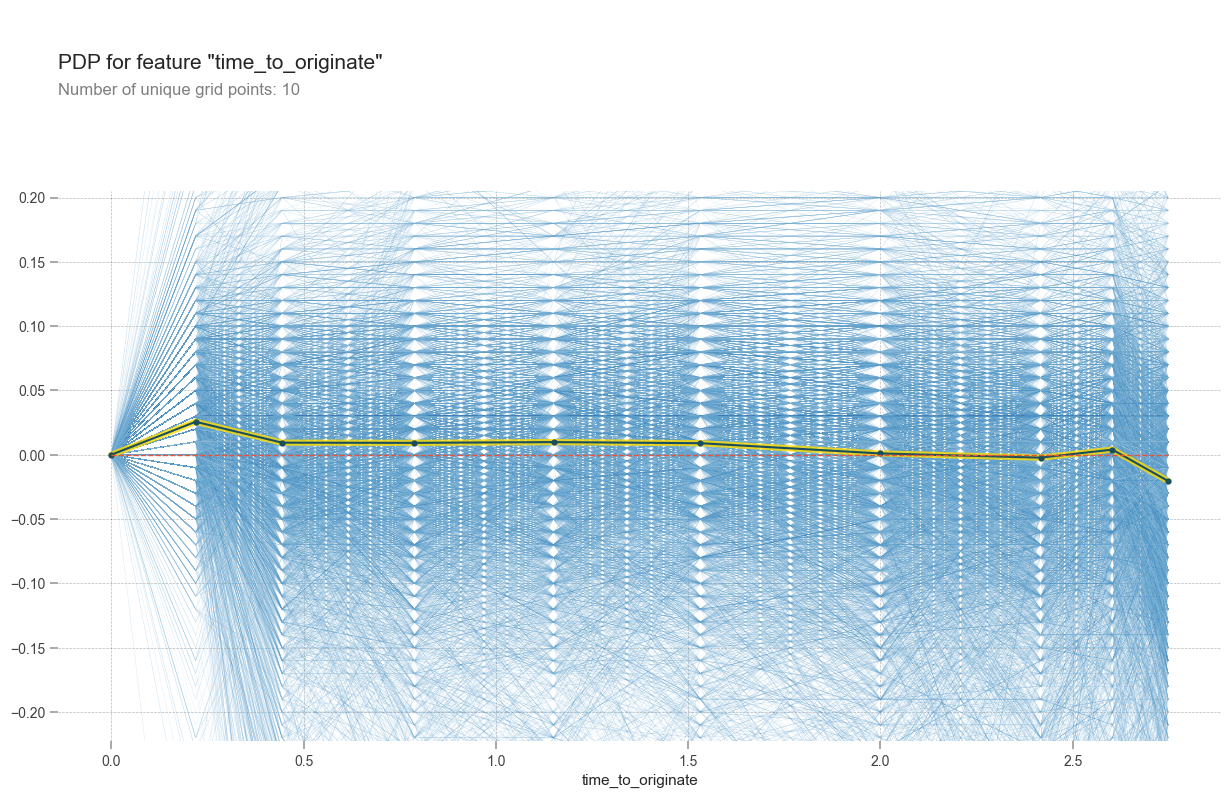

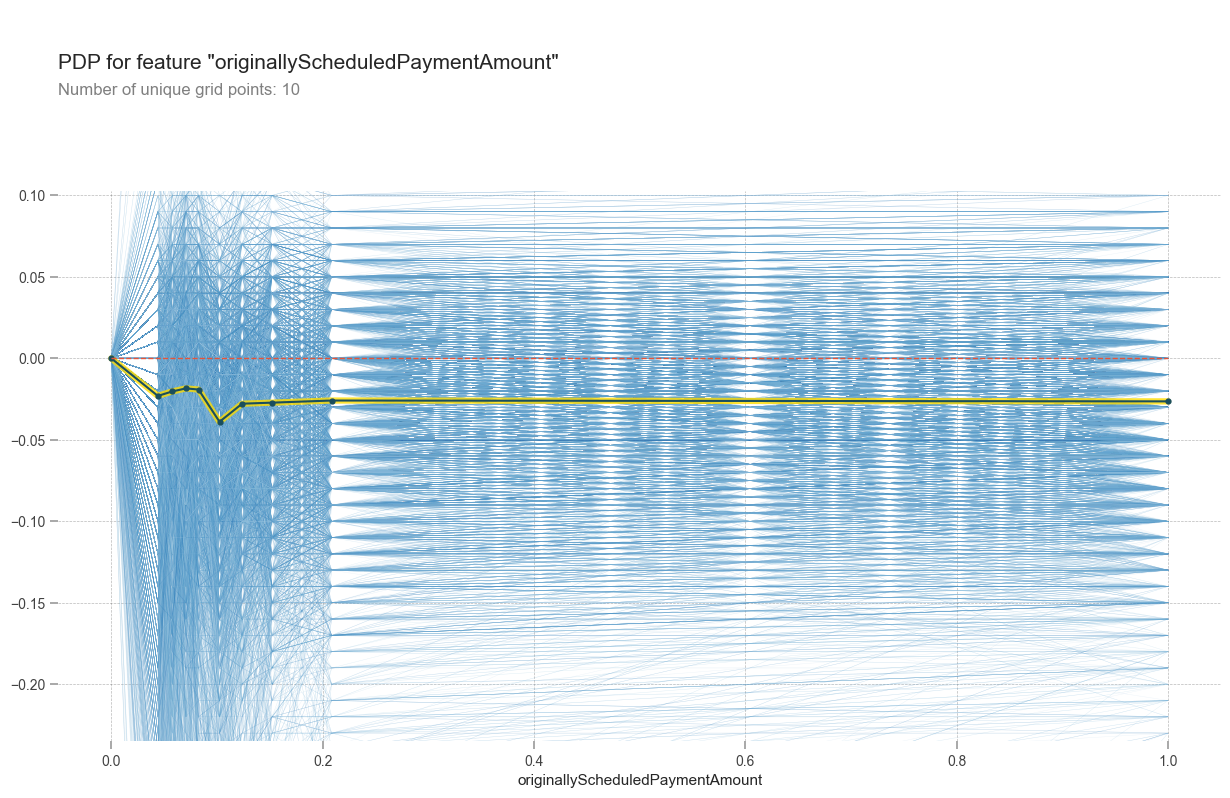

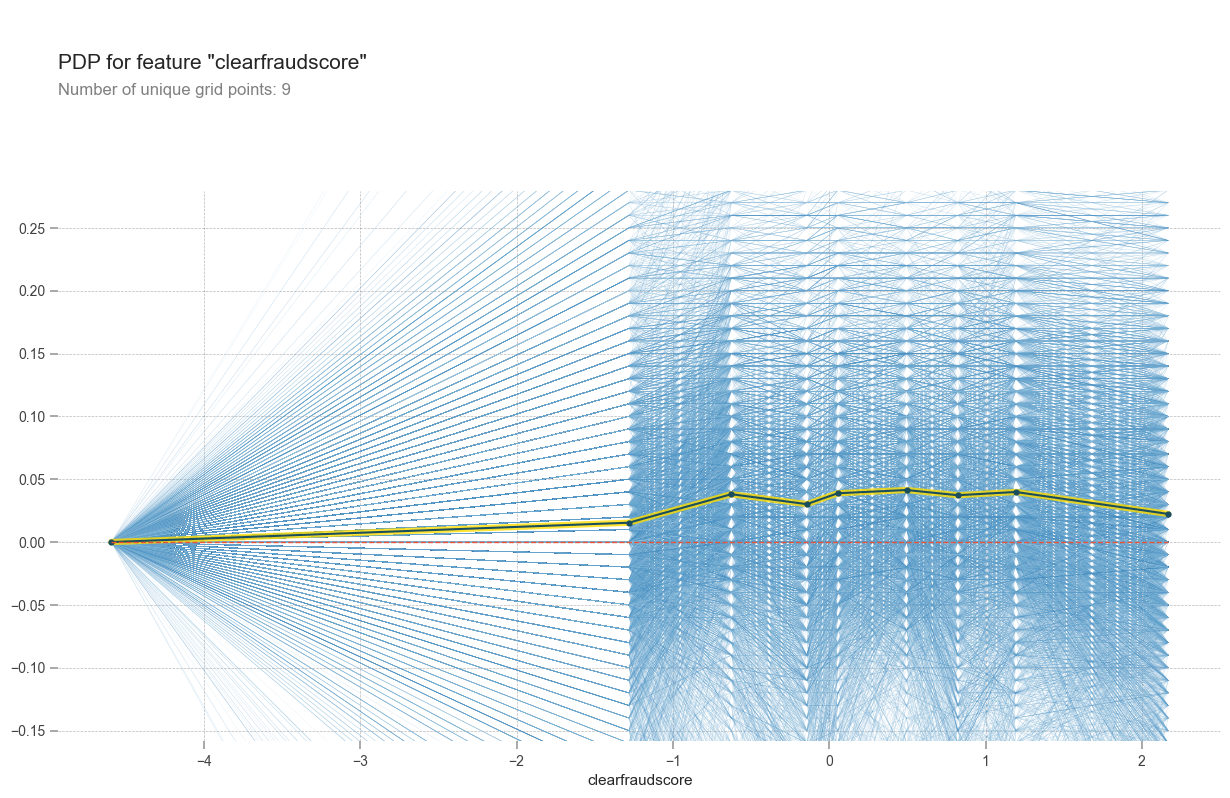

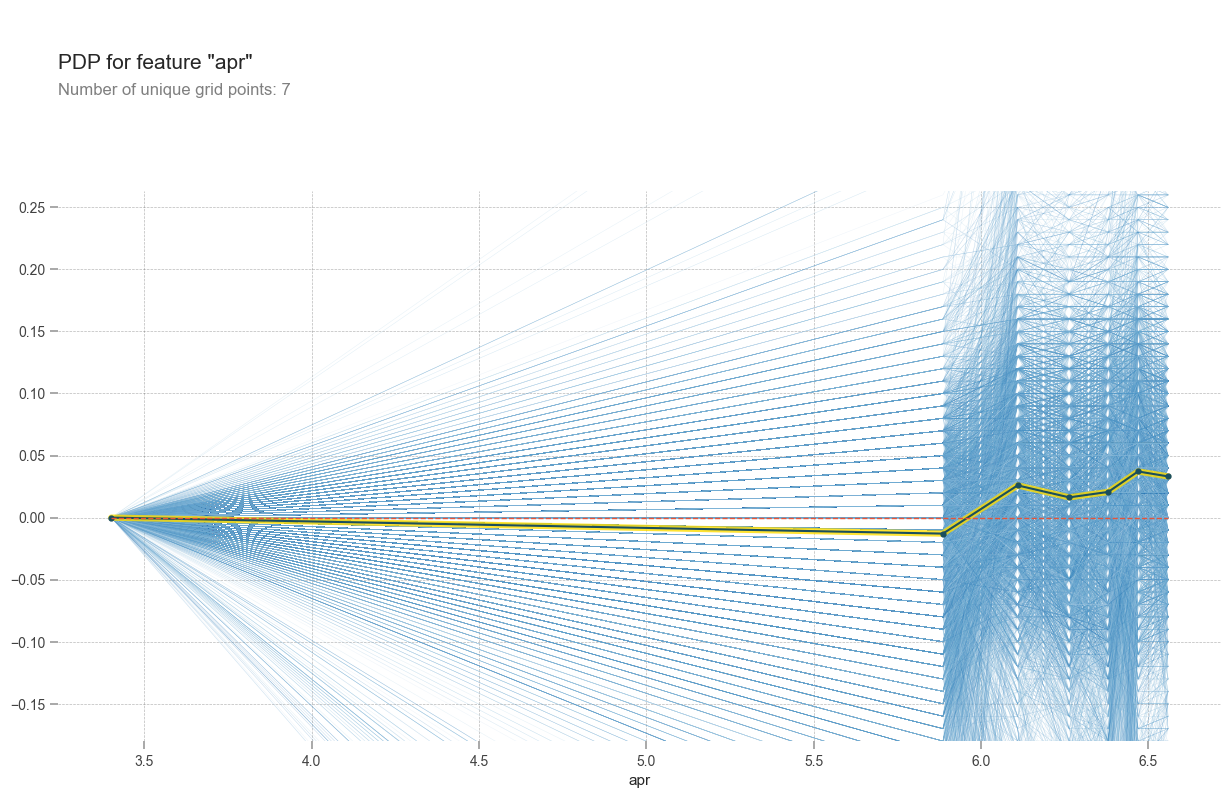

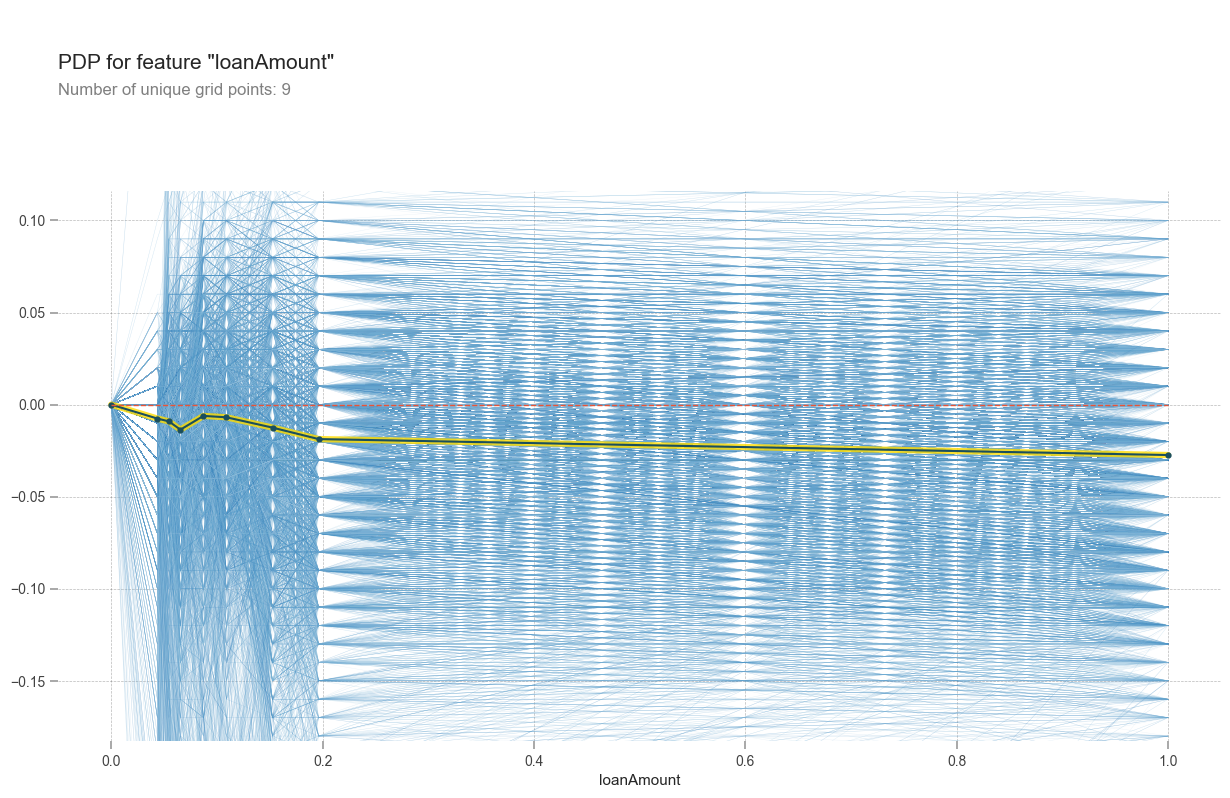

In [ ]:
# Create Partial Dependence Plots (PDP) for each of the top 5 most important features
for feature in indices[:5]:
    pdp_feature = pdp.pdp_isolate(model=clf, dataset=X, model_features=X.columns, feature=X.columns[feature])
    fig, ax = pdp.pdp_plot(pdp_feature, feature_name=X.columns[feature], plot_lines=True)
    plt.tight_layout()
    plt.savefig(f'../images/pdp_{X.columns[feature]}.png', format='png')
    plt.show()

We gather the following insights:
- The longer it takes for an application to originate, the higher the probability of default; loans that are originated soon after the application date are more likely to be paid in full. We suspect that this may be because clients with their "ducks in a row" simply pass through an automated origination filter, leading to quicker turnarounds, whereas clients that don't have to wait for their applications to be manually inspected. Though, without more knowledge of the origination process, it's hard to draw any concrete conclusions.
- The higher the clear fraud score, the lower the probability of default (consistent with expectations).
- The higher the financial obligations of the loan, the higher the probability of default (consistent with expectations).

# 5. Conclusions

Throughout this notebook, we've extracted key business insights from the available data, used our findings to engineer relevant features, and experimented with different model configurations, ultimately deciding on a Random Forest Ensemble for this binary classification task. At an ROC-AUC score of 99.90%, we can safely conclude that our model is performing at a more-than-acceptable benchmark!

## 5.1 Further Work

To end our discussions, we'll address some final takeaways:

1. Upon further inspection, we realize that the data in `payment.csv` could be used to engineer additional features, mainly to do with the reliability of a given client (e.g. "does this client tend to stick to the original payment schedule?", "how many repayments per loan?", etc.) However, we felt it sufficient to address this mistake here, rather than correct it in the notebook itself, since the available features were (at least somewhat) analogous to what we would've gotten had we used `payment.csv` in the first place. Regardless, implementing this change would require some care towards preventing target leakages, as a model would not have access to a client's repayment habits at the time of their first application, for example. The same considerations would apply towards preventing train/test leakages.

2. On the topic of additional features, we recommend acquiring the following client data to further improve model performance:

    - Income
    - Credit score/history
    - Debt
    - Employment history
    - Purpose of loan
    - Loan-to-value ratio of collateral (if any)

    Using these data, we can engineer more relevant features, such as `loan_duration`, `loan_to_income_ratio`, `payment_to_income_ratio`, `income_source`, `employment_length`, `home_ownership_status`, etc. However, without a better understanding of the context of these loans (from MoneyLion's perspective), it's difficult to say whether acquiring these data would be appropriate or not.

3. Finally, we address the topic of incorporating demographic data into our analyses. In general, it's not recommended to include features such as race, gender, ethnicity, etc. into a model that's used to make lending decisions, due to the potential for bias, discrimination, and unfair treatment towards clients belonging to minority groups. Hence why we omitted `state` as a feature to our model, and why we did not recommend collecting similar data in our previous point. However, should the primary use of the model be to gain insights into & help address disparities in lending outcomes, then our argument may change. Though otherwise, we should not only avoid using demographic features when training our model, but also constantly monitor the model post-deployment for any signs of bias & discrimination.

---
Notebook runtime: ~15 mins

Time spent: 40 - 50 hours